In [1]:
import sys
sys.path.insert(0, '../')
from NE204_Functions import *

plt.rcParams['figure.dpi'] = 300

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.mixture import GaussianMixture

Plots directory already exists


In [2]:
data, saturated = import_data('../Lab-1/Data/Combined_Data/Cs137-24in-2.h5')

In [3]:
energies, energies_inds = calibrate_pulses(data, return_inds=True)

Creating spectra:   0%|          | 0/16145 [00:00<?, ?it/s]

In [4]:
energies_test, energies_inds_test = import_lab1_energies('Cs137', indexes=True)

Loading in calibrated Cs137 spectra


Peak energy: 661.7090977822412
Calculated resolution: 0.913%


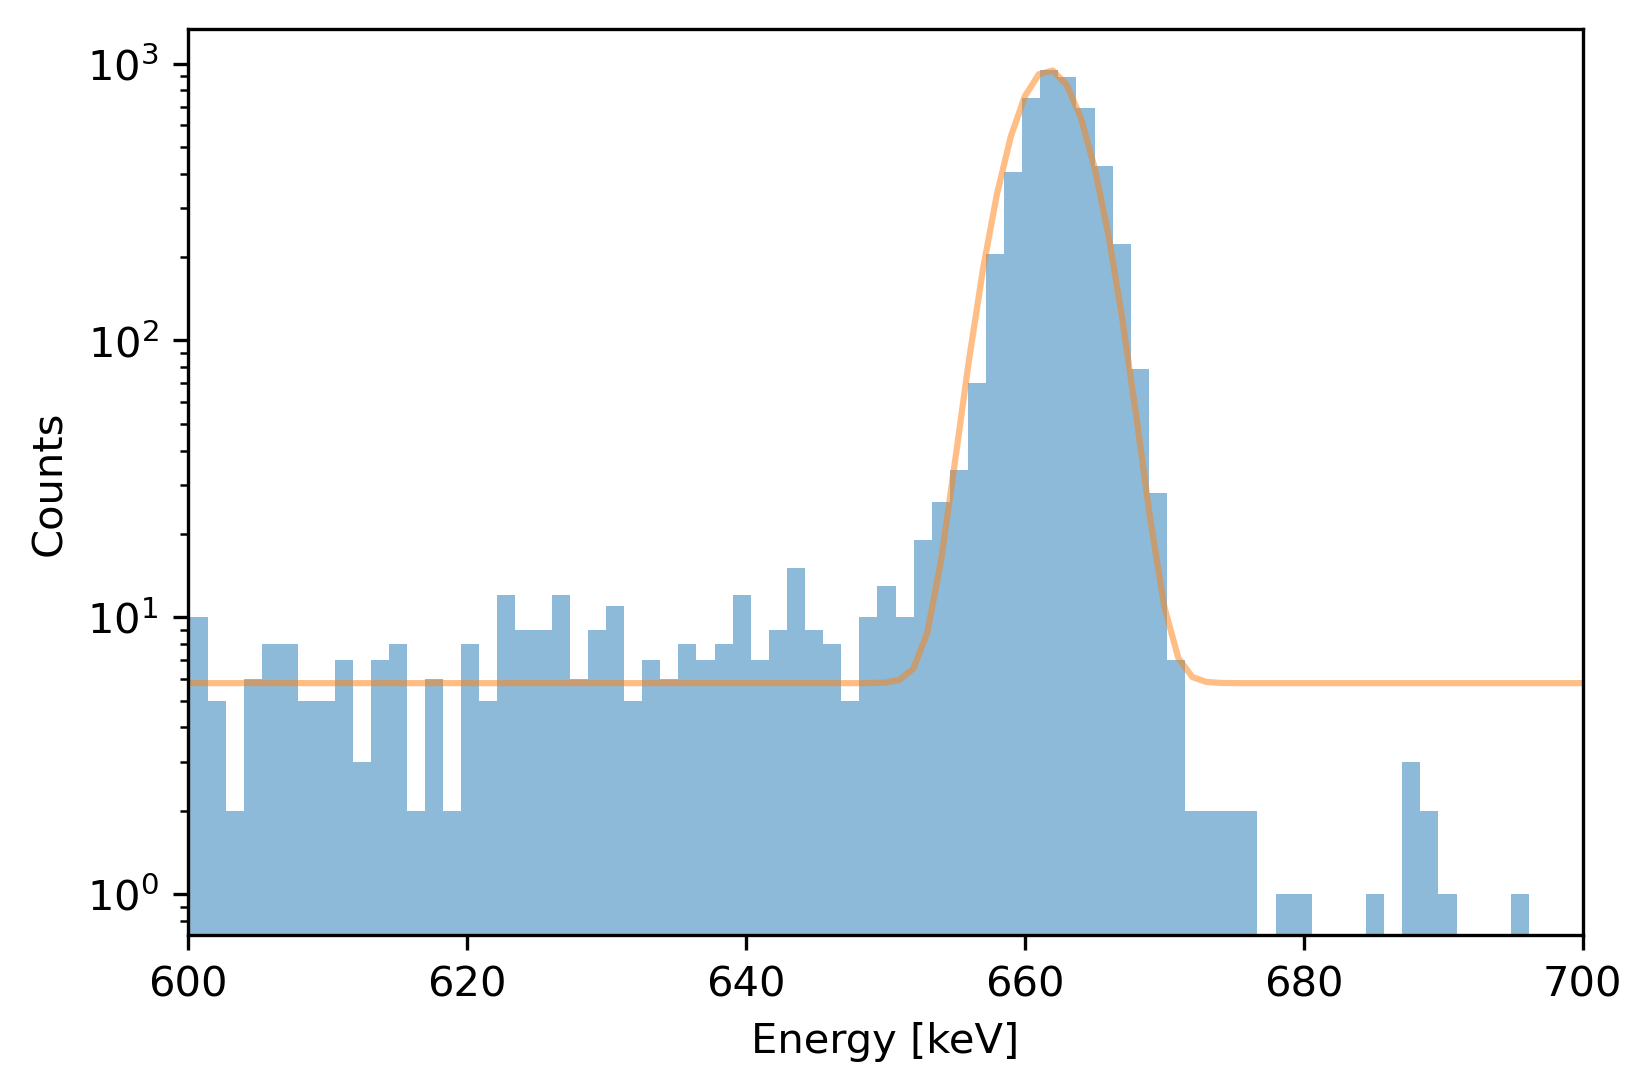

In [6]:
quick_resolution(energies_old, 600, 700)

In [11]:
def reset_zero(signal, samp_size=500):
    return signal - np.mean(signal[:samp_size])

def CFD(signal, frac, shift=500, pf=False):
    signal = reset_zero(signal)
    mod_signal = (-frac*signal)[shift:]
    CFD_result = signal[:len(signal)-shift]+mod_signal
    
    if pf:
        return mod_signal, CFD_result, np.argwhere(np.where(CFD_result>0, 0, CFD_result)!=0)[-1][0] 
    else:
        return np.argwhere(np.where(CFD_result>0, 0, CFD_result)!=0)[-1][0] 

In [6]:
cs_photopeak_inds = np.argwhere((energies>=652) & (energies<=670))
cs_photopeak_inds = cs_photopeak_inds.reshape(len(cs_photopeak_inds),)
cs_photopeak_inds = energies_inds[cs_photopeak_inds]

cs_photopeak = np.copy(data[cs_photopeak_inds])

In [6]:
energy = calibrate_pulses(data[cs_photopeak_inds[21]].reshape(1,len(data[0])))

Creating spectra:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
energy

array([], dtype=float64)

In [106]:
data[cs_photopeak_inds[21]].reshape(1,len(data[0]))

array([[7913, 7906, 7912, ..., 8141, 8147, 8144]], dtype=uint16)

In [61]:
calibrate_pulses(data[cs_photopeak_inds[2775]].reshape(1,62500))

Creating spectra:   0%|          | 0/1 [00:00<?, ?it/s]

array([662.14101515])

In [68]:
cs_photopeak_inds[703]

2322

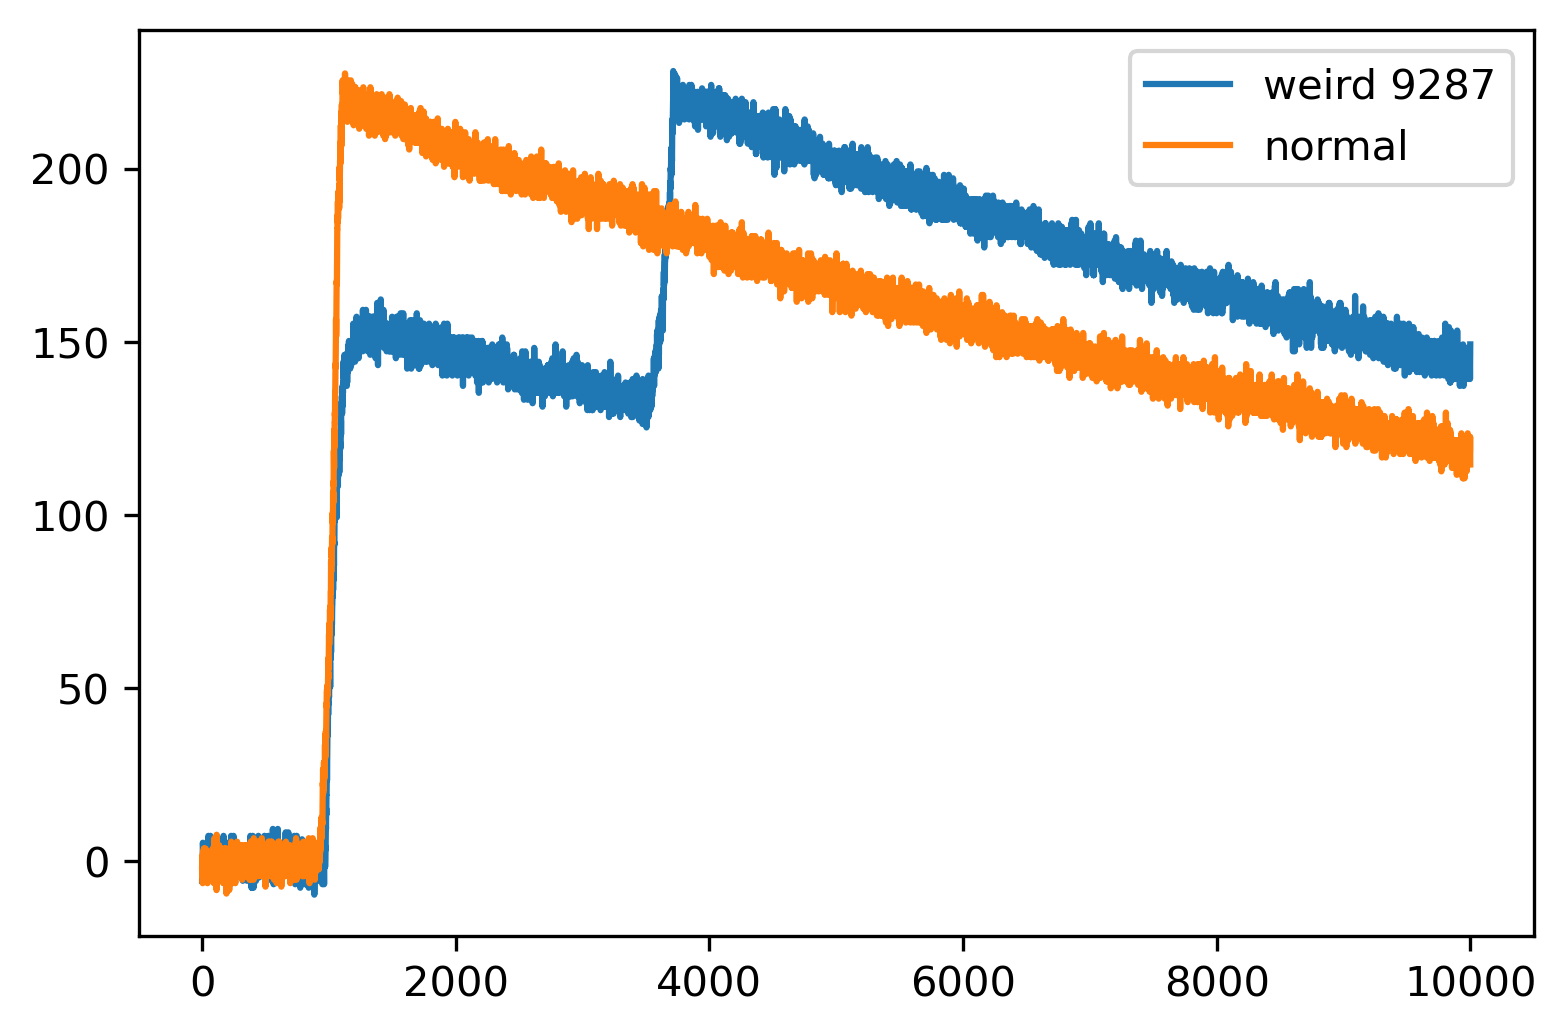

In [9]:
end = 10000
plt.plot(reset_zero(cs_photopeak[2775][:end]), label='weird {}'.format(cs_photopeak_inds[2775]))
plt.plot(reset_zero(cs_photopeak[2][:end]), label='normal')
plt.legend()
plt.show()

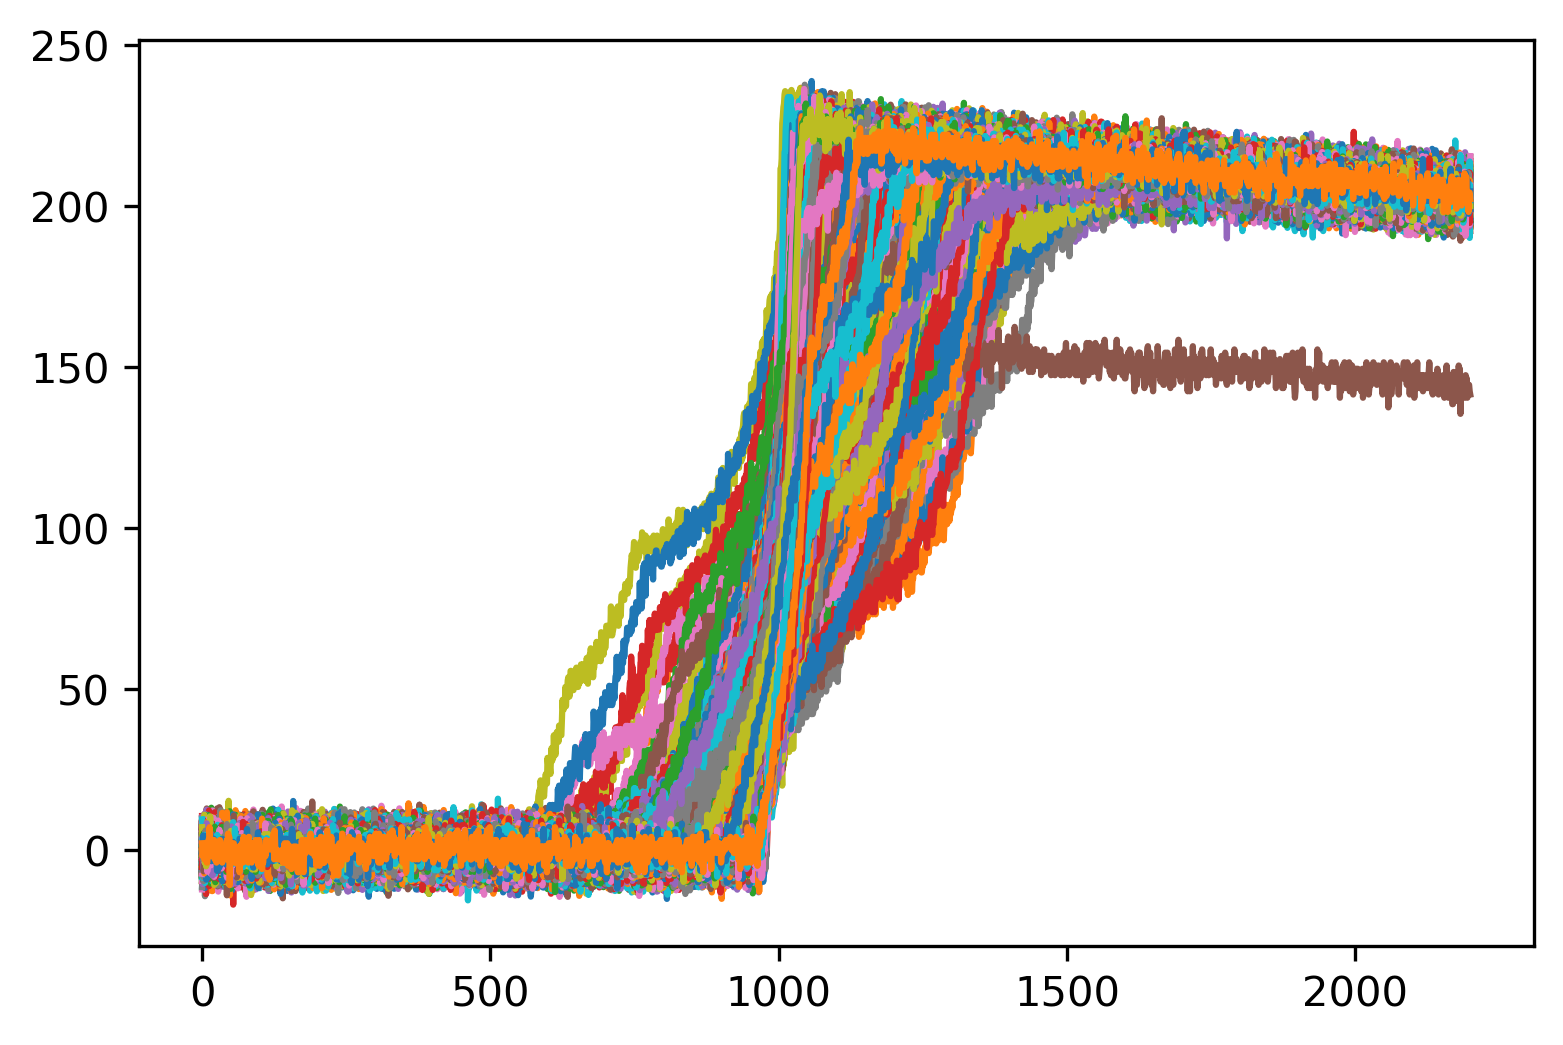

In [7]:
for i in range(len(cs_photopeak)):
    plt.plot(reset_zero(cs_photopeak[i][:2200]))
#plt.ylim(7700,9000)

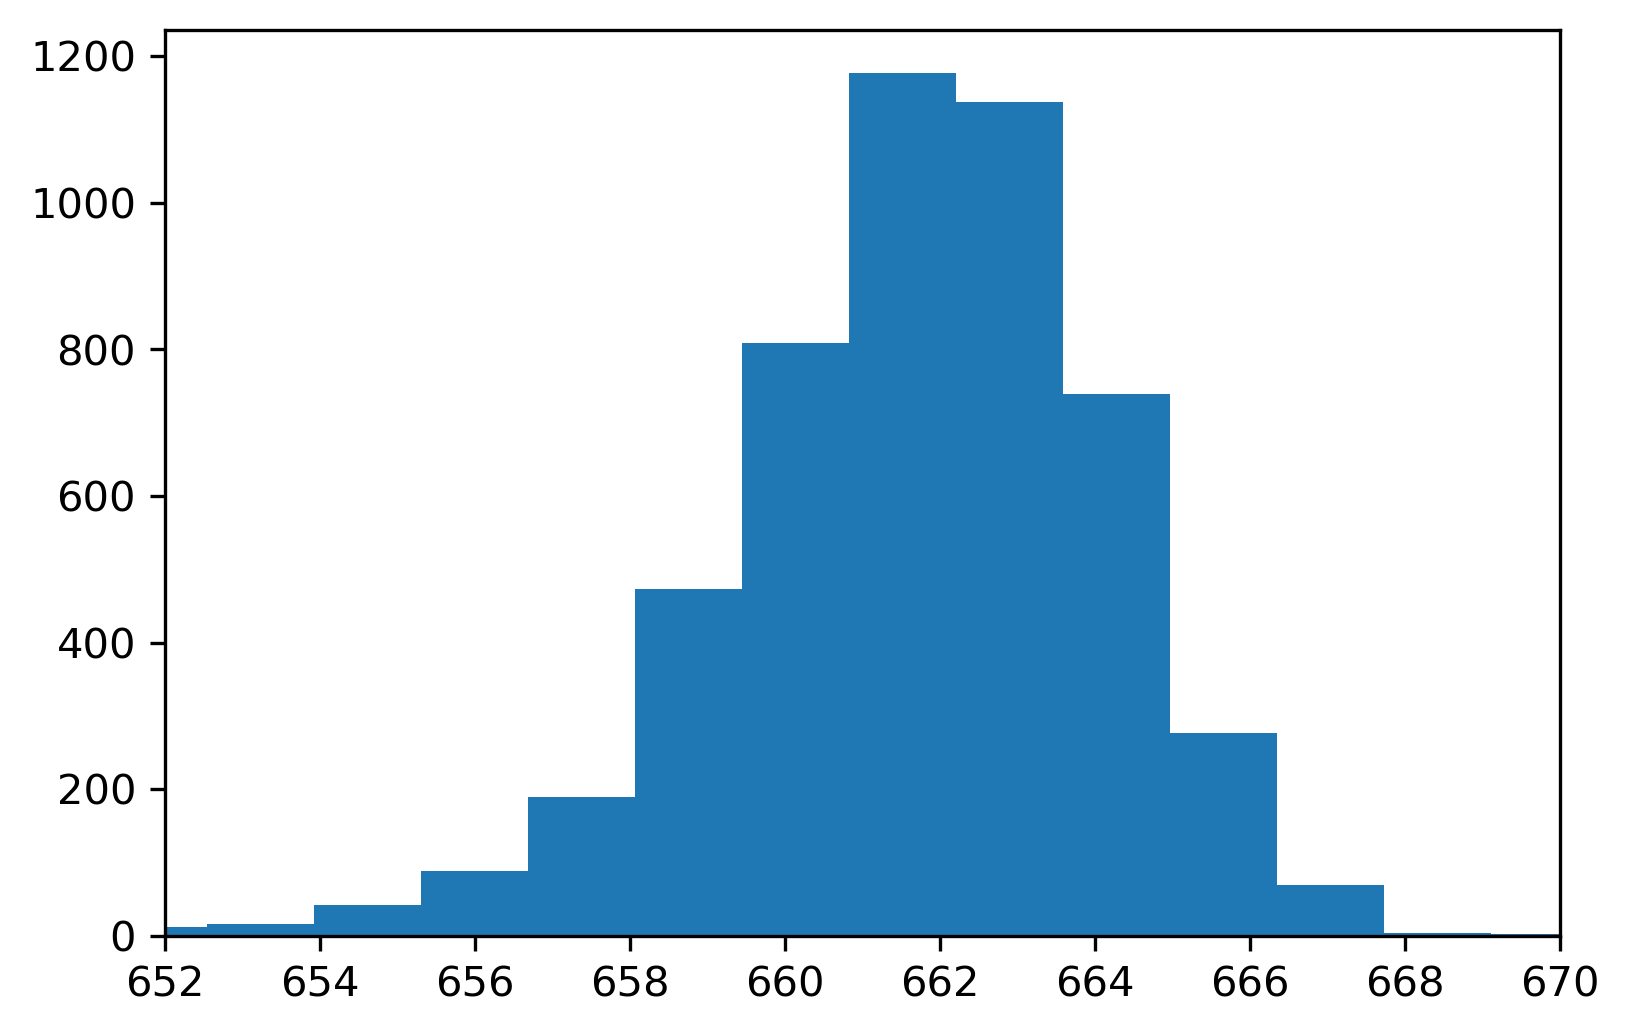

In [27]:
plt.hist(energies, bins=2**11)
plt.xlim(652,670)
plt.show()

In [7]:
rise_times = []
for d in tqdm(data):
    signal = savgol_filter(d[:2500], 51, 0)
    rise_times.append(CFD(signal, 0.9)-CFD(signal, 0.1))
rise_times = np.array(rise_times)

rise_times_photopeak = []
for i in tqdm(cs_photopeak_inds):
    signal = savgol_filter(data[i[0]][:2500], 51, 0)
    rise_times_photopeak.append(CFD(signal, 0.9)-CFD(signal, 0.1))
rise_times_photopeak = np.array(rise_times_photopeak)

  0%|          | 0/16991 [00:00<?, ?it/s]

  0%|          | 0/5028 [00:00<?, ?it/s]

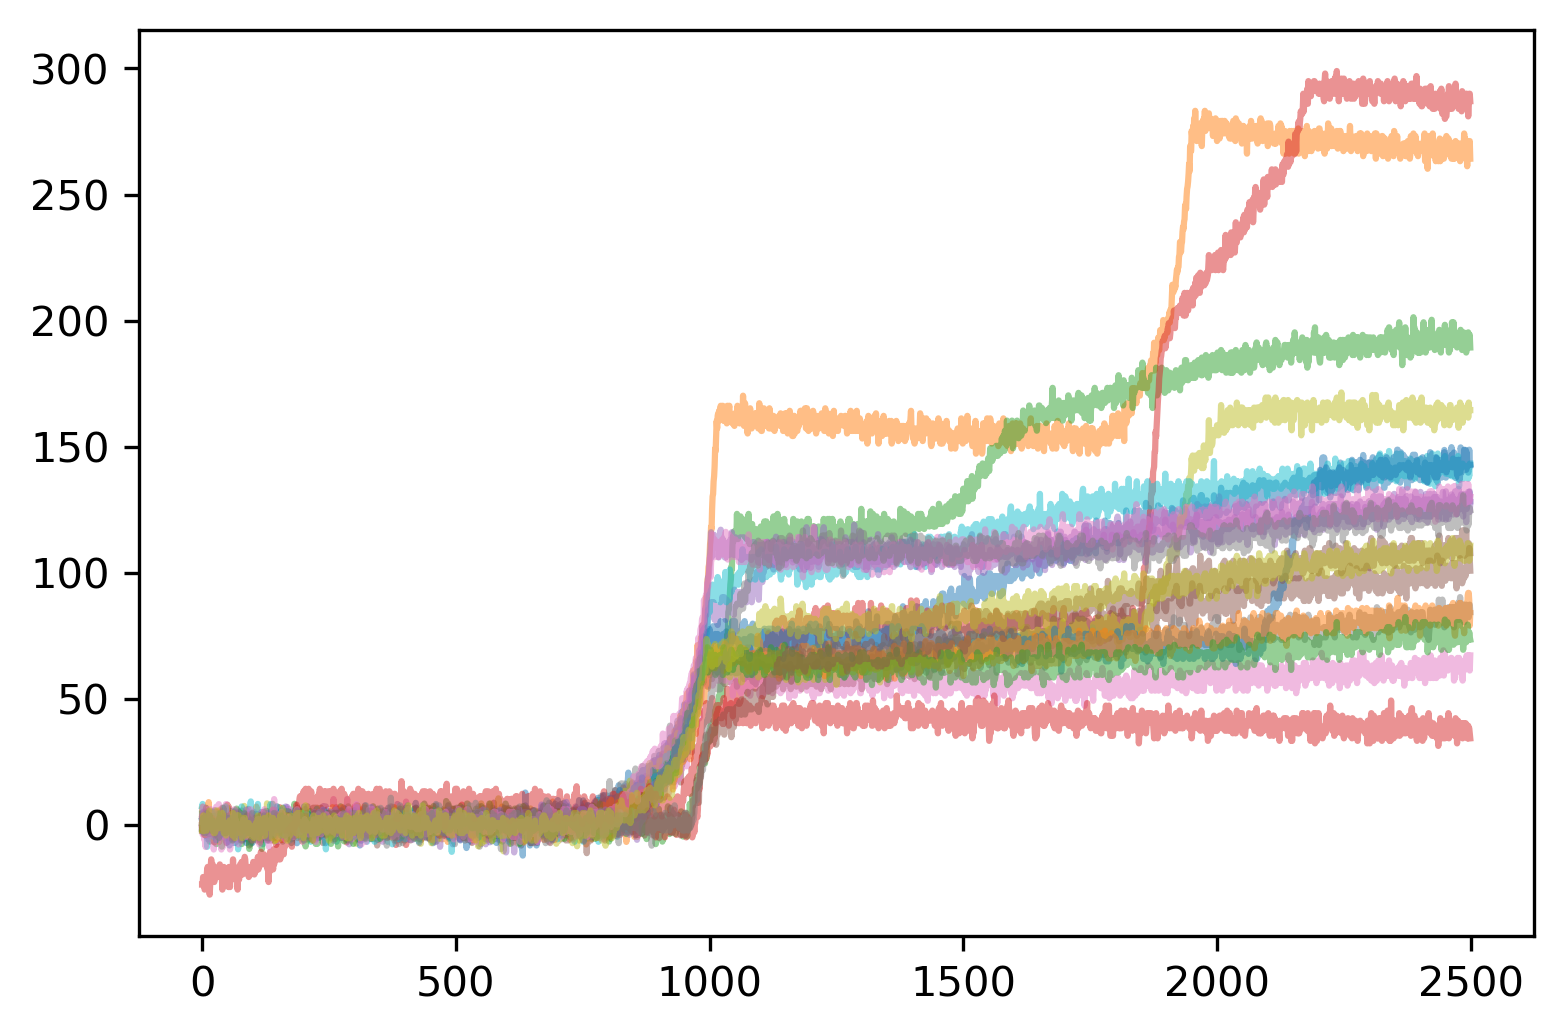

In [61]:
for i in [cs_photopeak_inds[i[0]][0] for i in np.argwhere(rise_times_photopeak > 800)]:
    plt.plot(reset_zero(data[i][:2500]), alpha=0.5)

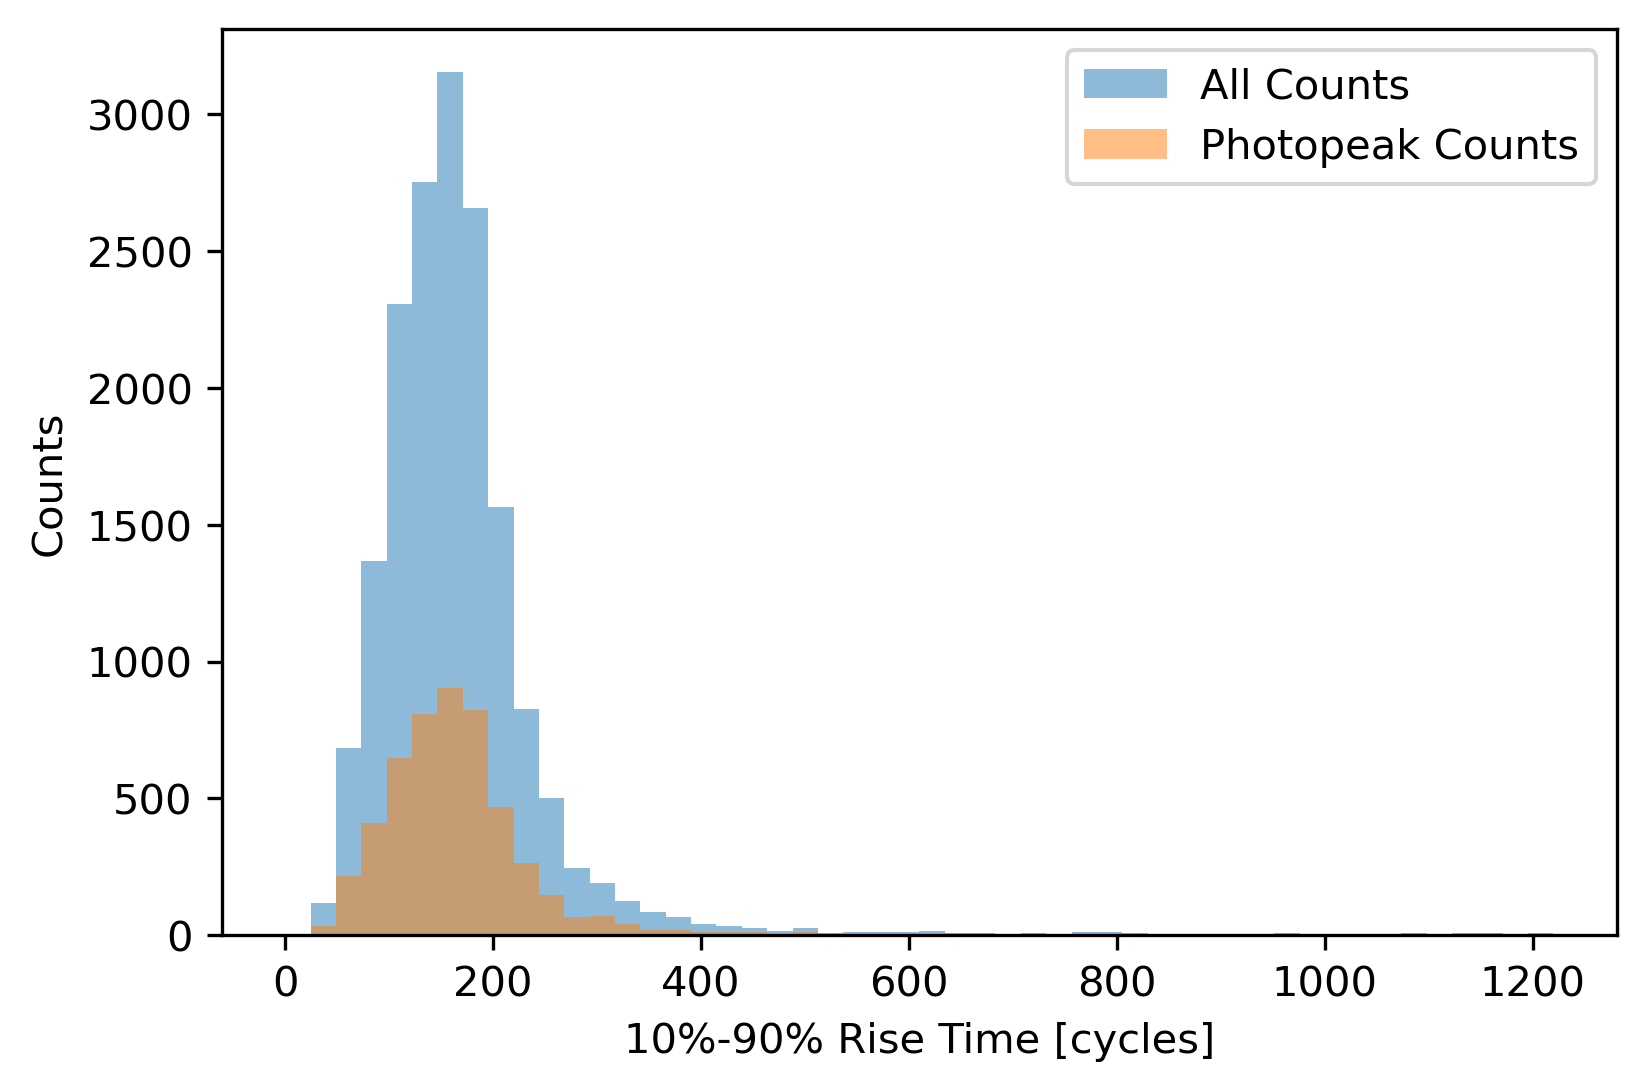

In [8]:
bins = np.linspace(0, 1220, 51)
plt.hist(rise_times, bins=bins, alpha=0.5, label='All Counts')
plt.hist(rise_times_photopeak, bins=bins, alpha=0.5, label='Photopeak Counts')
plt.ylabel('Counts')
plt.xlabel('10%-90% Rise Time [cycles]')
plt.legend()
plt.show()

In [158]:
cs_photopeak_zero = []
for p in tqdm(range(len(cs_photopeak))):
    start = determine_rise(savgol_filter(cs_photopeak[p][:2200], 51, 0))
    #sig = savgol_filter(reset_zero(cs_photopeak[p][start:start+1100]), 51, 0)
    sig = reset_zero(cs_photopeak[p][start:start+1100], samp_size=50)
    cs_photopeak_zero.append(sig/max(sig))
cs_photopeak_zero = np.array(cs_photopeak_zero)

  0%|          | 0/4802 [00:00<?, ?it/s]

In [60]:
scaler = StandardScaler()
scaled_photopeaks = scaler.fit_transform(cs_photopeak_zero)

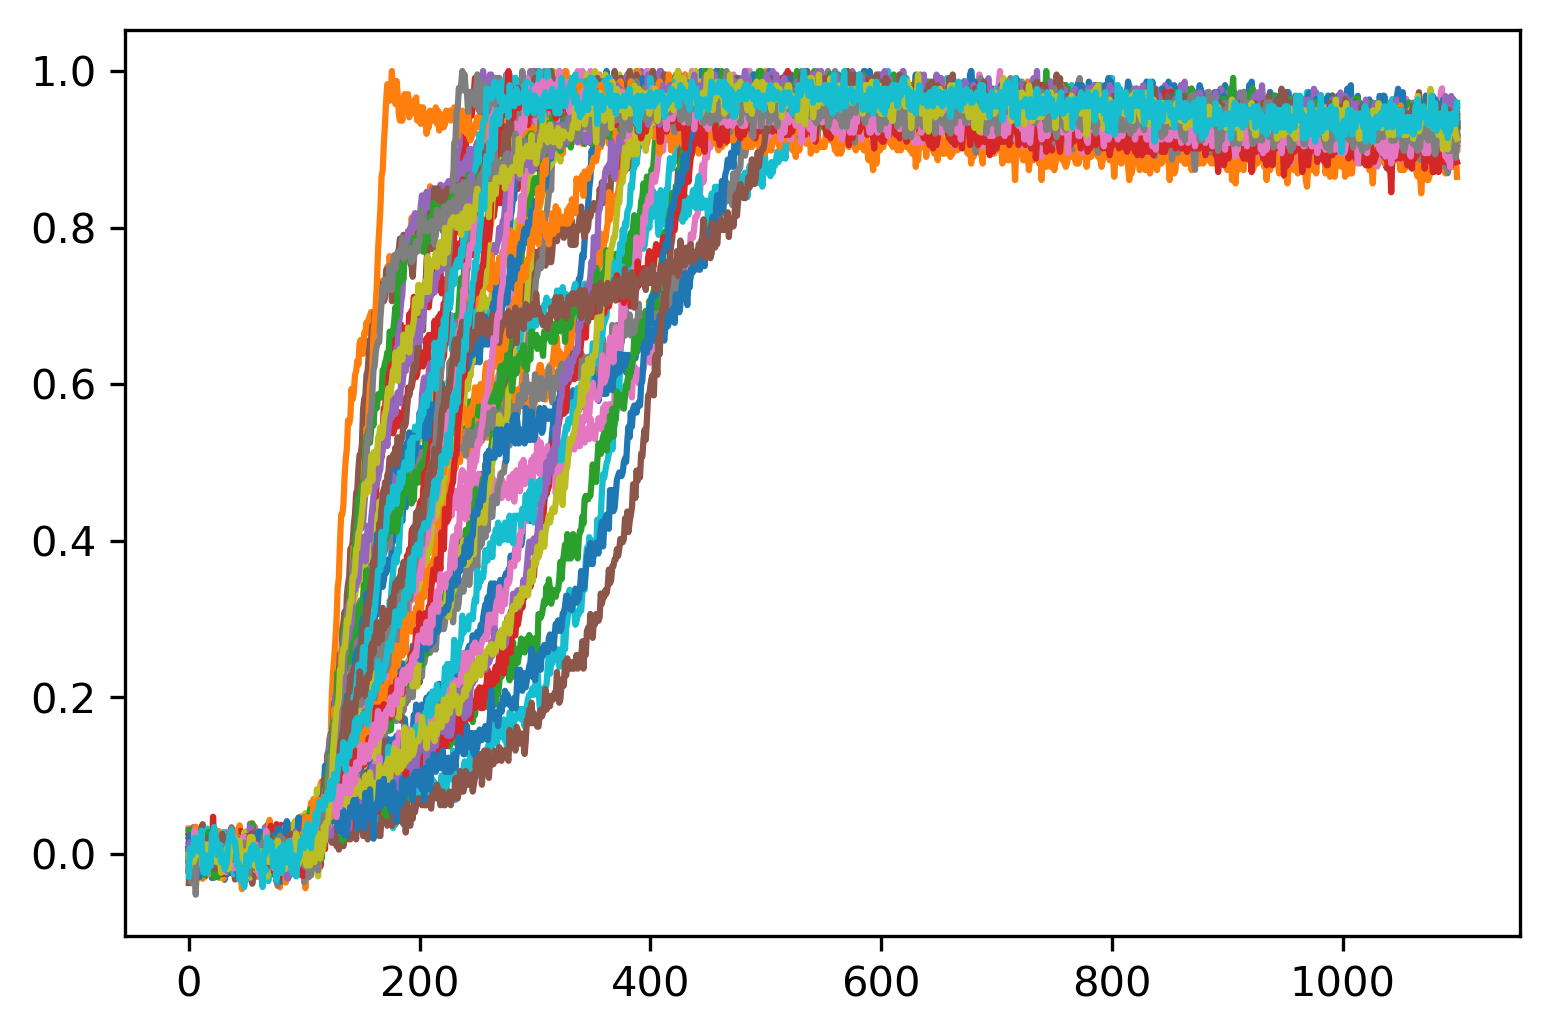

In [34]:
for i in range(50):
    plt.plot(cs_photopeak_zero[i])

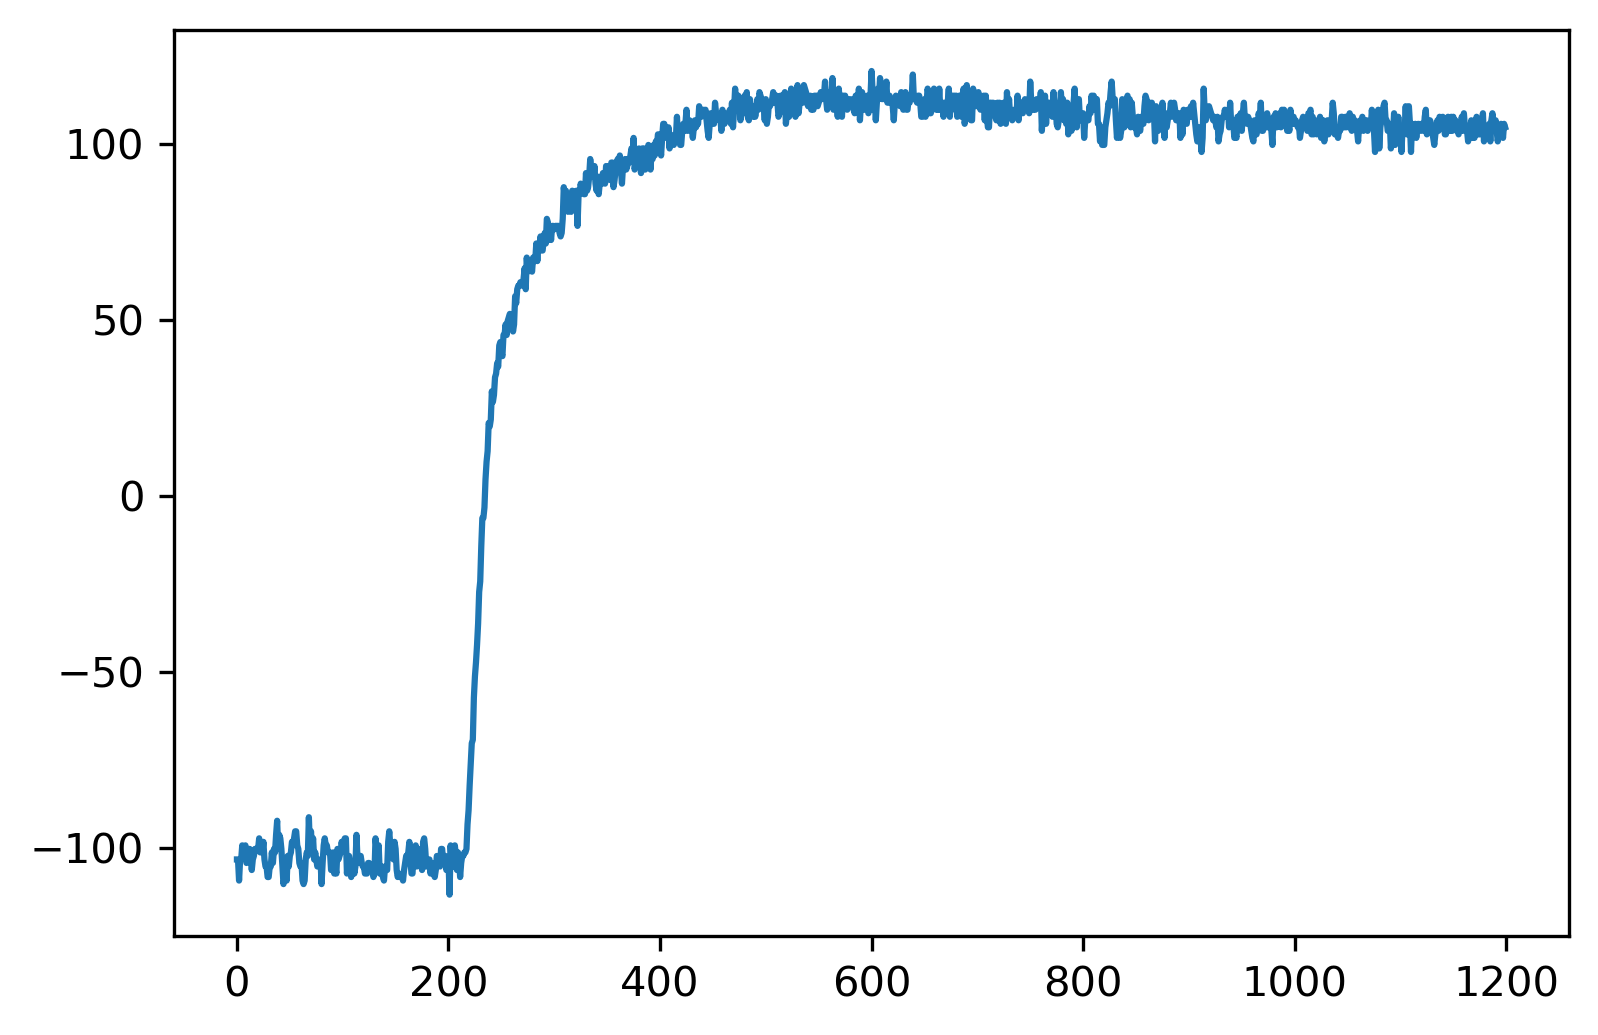

In [21]:
p = 1
start = determine_rise(savgol_filter(cs_photopeak[p][:2200], 51, 0))
plt.plot(reset_zero(cs_photopeak[p][start-100:start+1100]))

In [115]:
kmeans = KMeans(init="random",n_clusters=4, n_init=10,
    max_iter=300,random_state=42)

In [116]:
kmeans.fit(cs_photopeak_zero)

KMeans(init='random', n_clusters=4, random_state=42)

In [118]:
kmeans.cluster_centers_

array([[-6.74297464e-02, -5.23509253e-02, -4.20699109e-02, ...,
         2.07211528e+02,  2.07213585e+02,  2.07318451e+02],
       [-3.37468983e-03,  8.26468156e-02, -4.20181969e-03, ...,
         2.07994971e+02,  2.08006551e+02,  2.07933763e+02],
       [-1.00422741e-01, -3.48250729e-02,  5.99271137e-02, ...,
         2.06393017e+02,  2.06444038e+02,  2.06335437e+02],
       [-2.17847769e-03, -6.91076115e-02, -2.05511811e-02, ...,
         2.08635617e+02,  2.08430892e+02,  2.08629055e+02]])

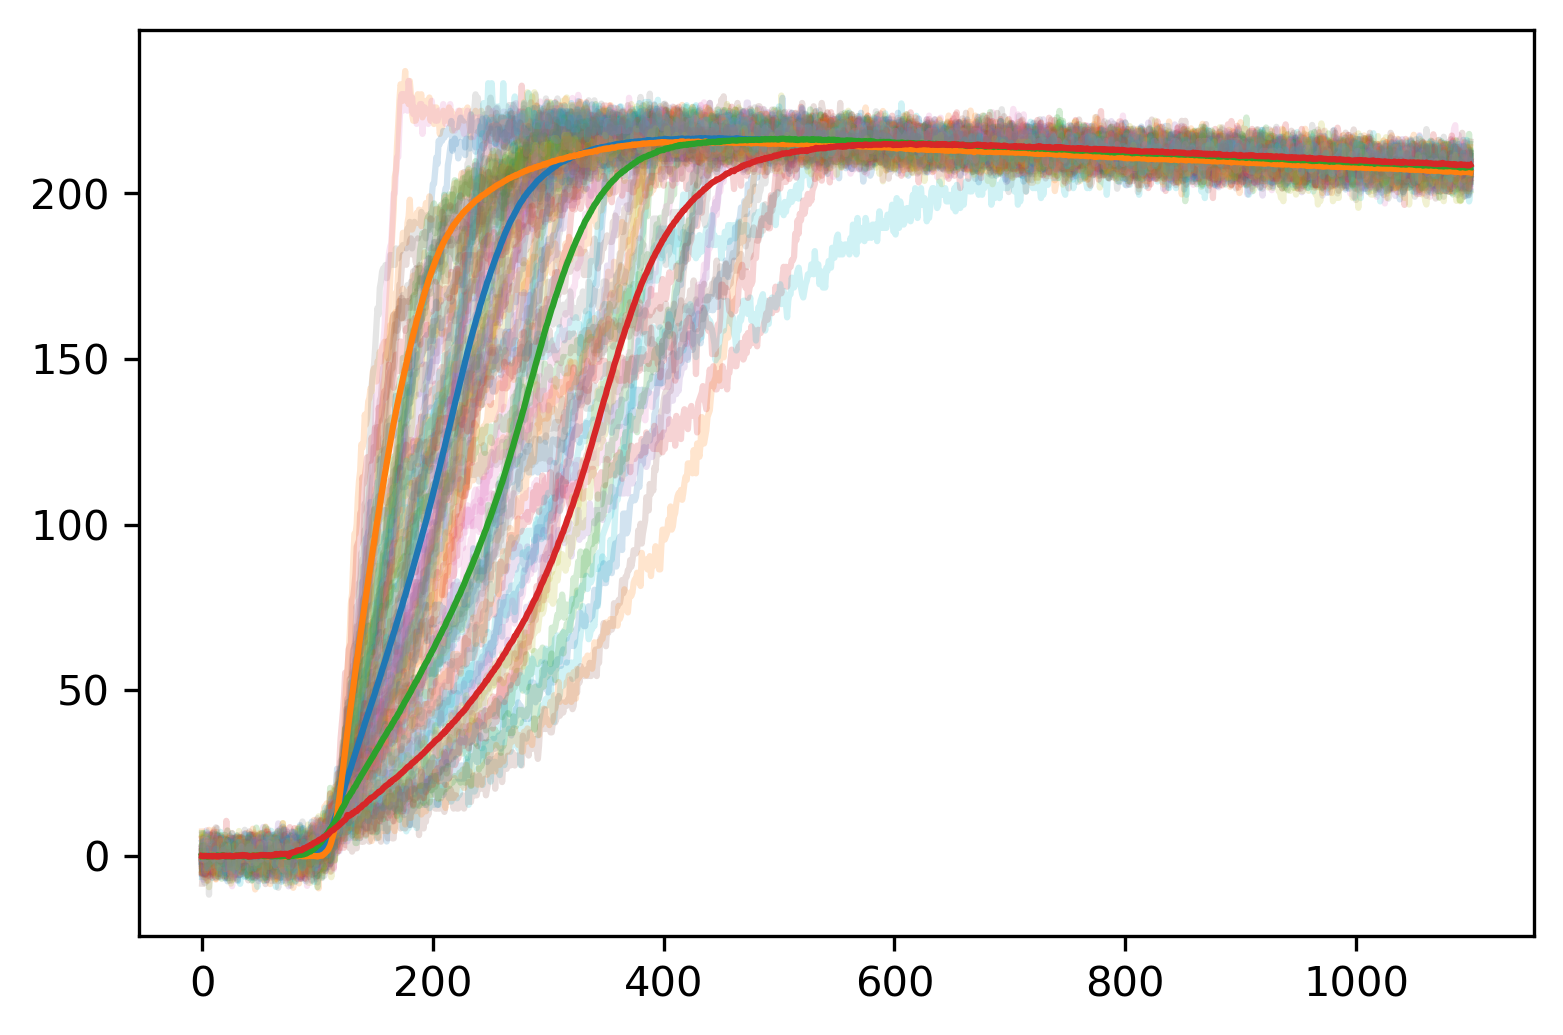

In [22]:
clu = 4
kmeans = KMeans(init="random",n_clusters=clu, n_init=100,
    max_iter=2000,random_state=42)

kmeans.fit(cs_photopeak_zero)

for i in range(100):
    plt.plot(cs_photopeak_zero[i], alpha=0.2)

for k in range(clu):
    plt.plot(kmeans.cluster_centers_[k])

In [76]:
kmeans.labels_

array([1, 2, 0, ..., 2, 0, 2], dtype=int32)

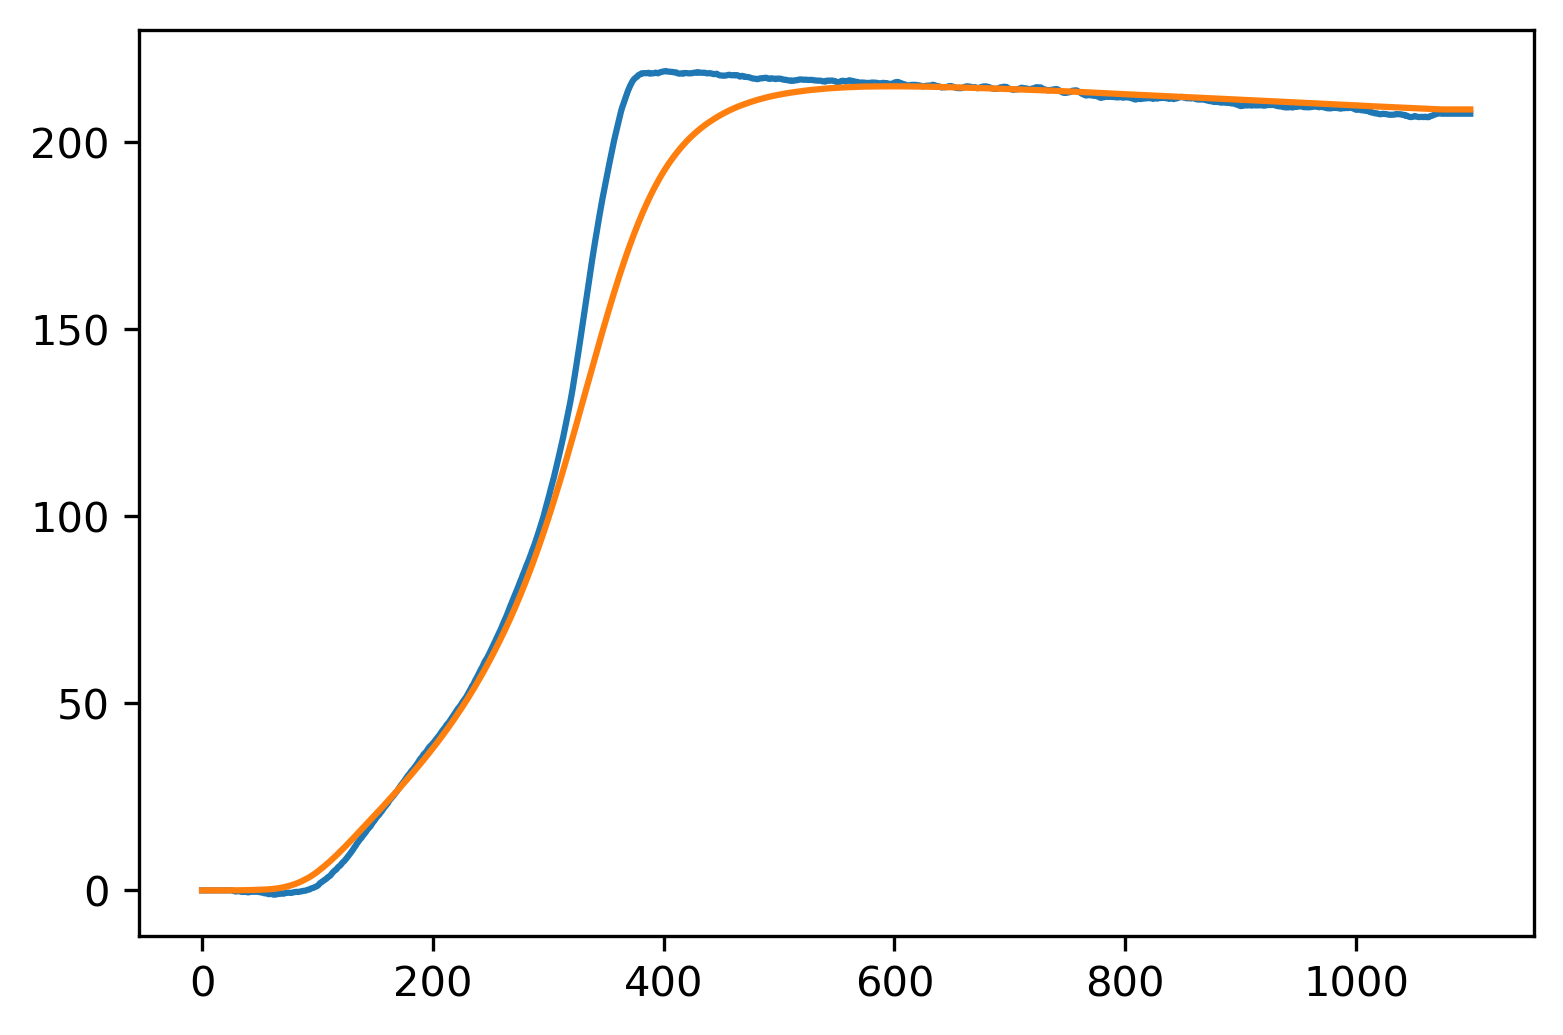

In [79]:
plt.plot(cs_photopeak_zero[0])
plt.plot(kmeans.cluster_centers_[1])

In [103]:
kmeans_kwargs = {"init": "random", "n_init": 100, "max_iter": 2000}

sse = []
for k in tqdm(range(1, 11)):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cs_photopeak_zero)
    sse.append(kmeans.inertia_)

  0%|          | 0/10 [00:00<?, ?it/s]

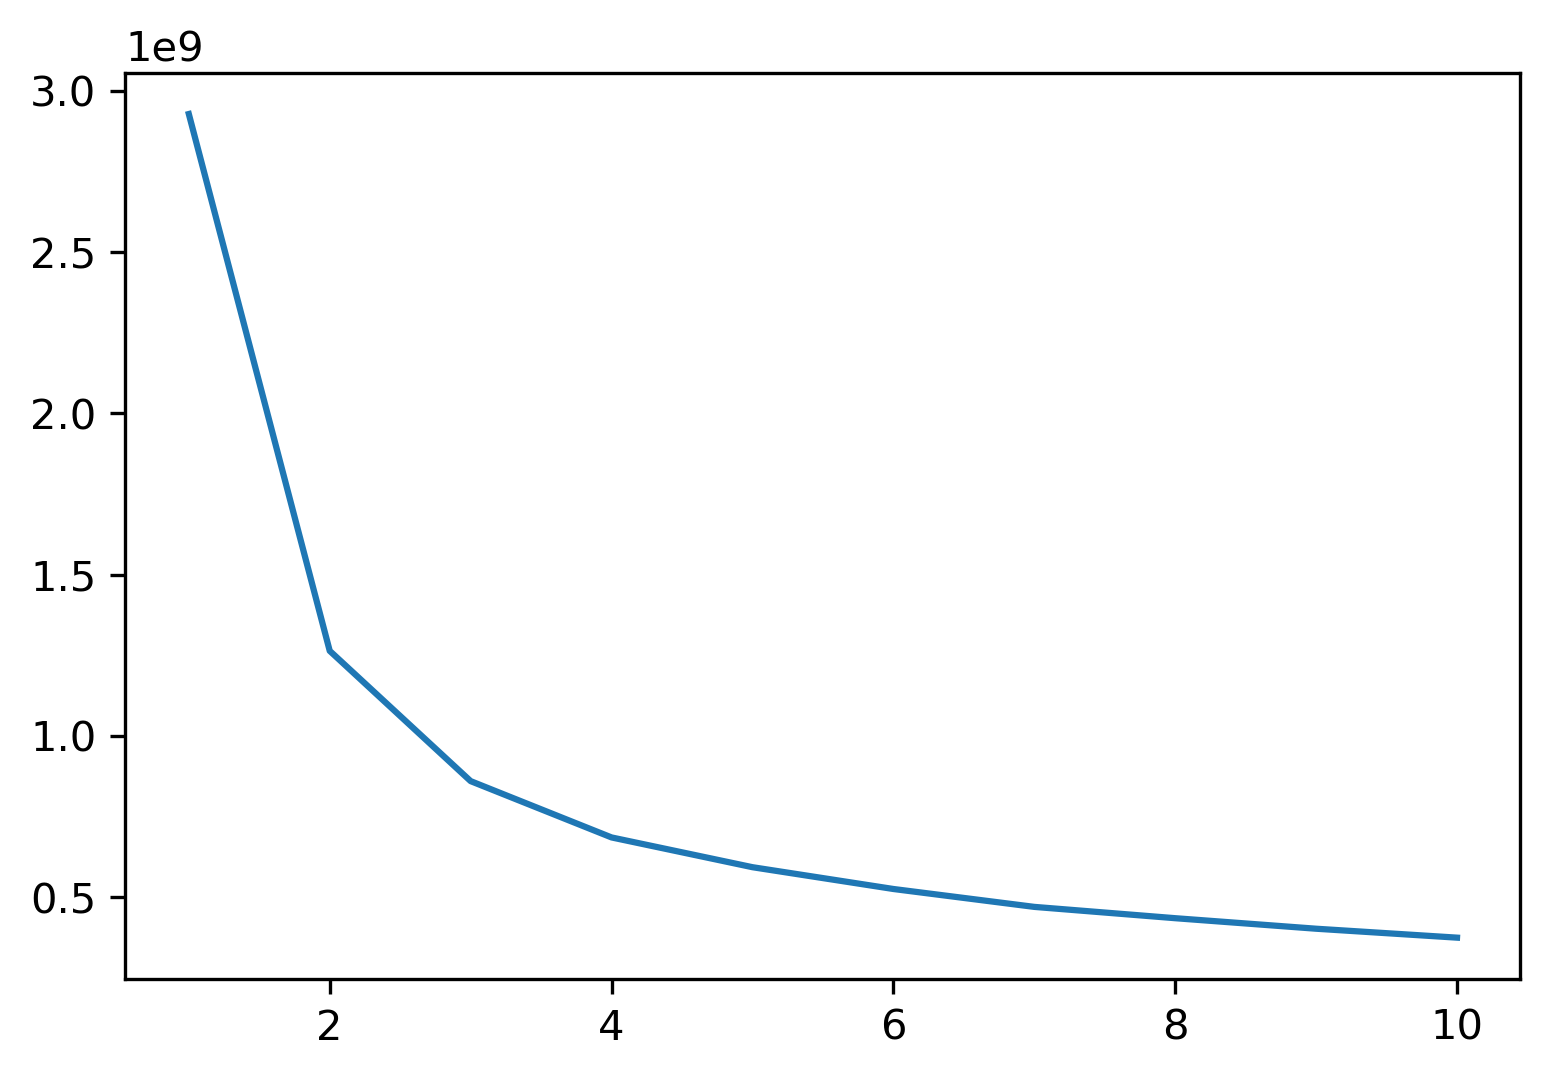

In [105]:
plt.plot(range(1,11), sse)

In [106]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

In [107]:
kl.knee

3

In [113]:
silhouette_coefficients = []

for k in tqdm(range(2, 11)):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cs_photopeak_zero)
    score = silhouette_score(cs_photopeak_zero, kmeans.labels_)
    silhouette_coefficients.append(score)

  0%|          | 0/9 [00:00<?, ?it/s]

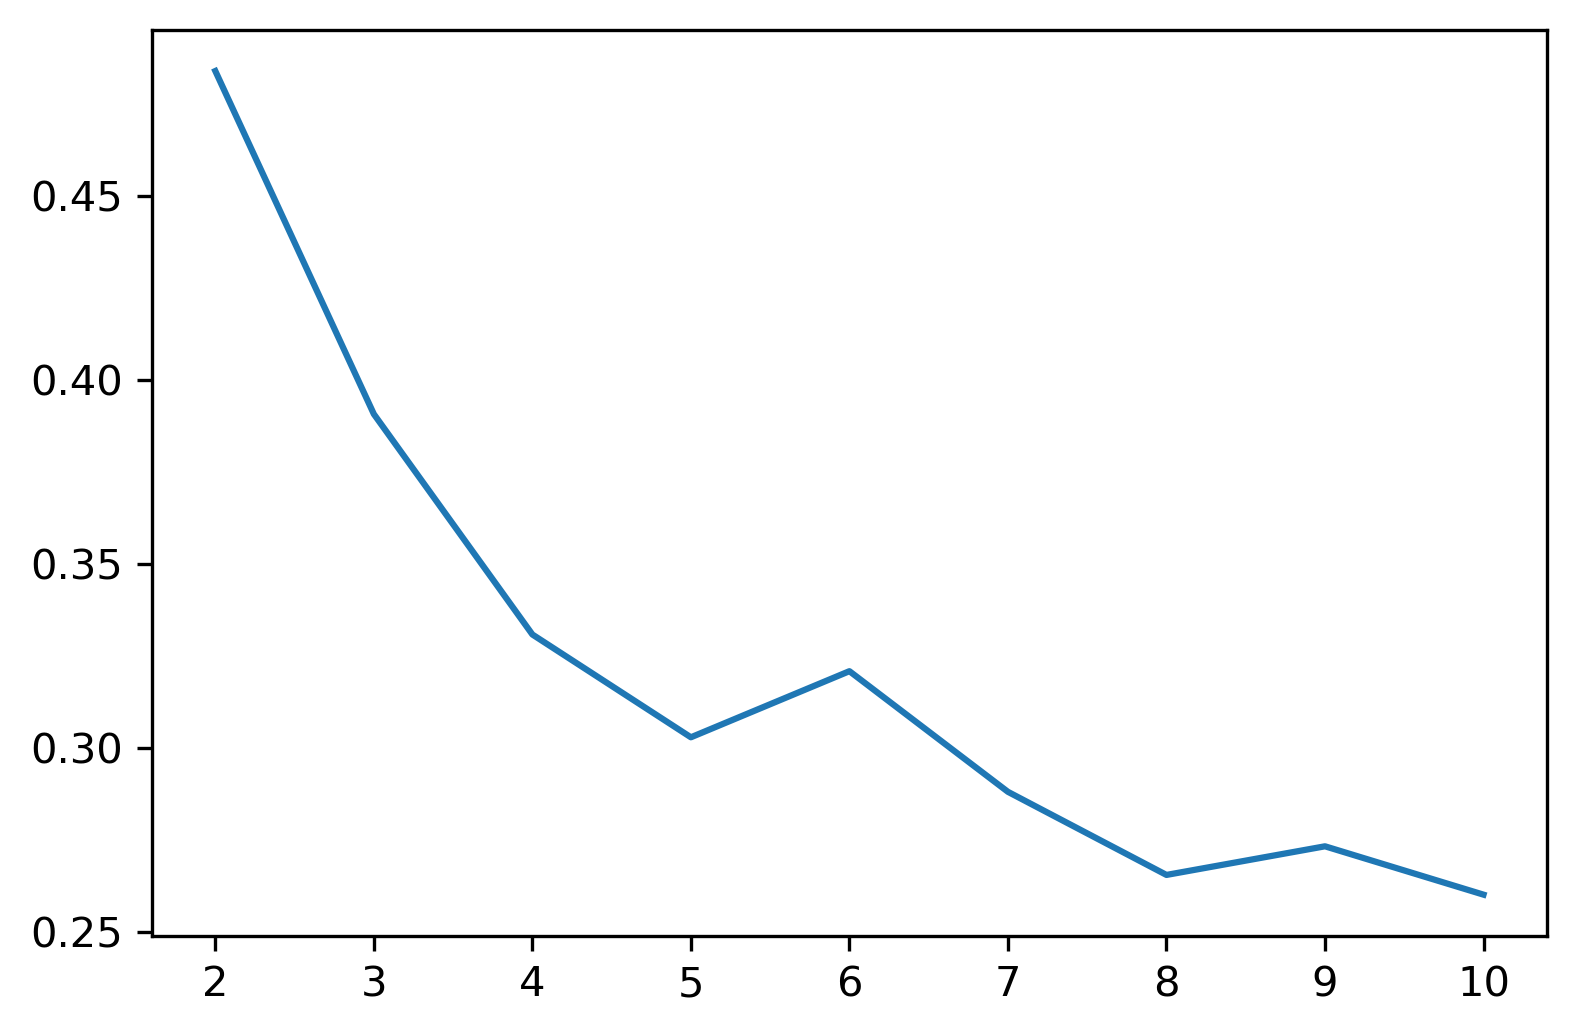

In [114]:
plt.plot(range(2,11), silhouette_coefficients)

In [39]:
n = 15
gmm = GaussianMixture(n_components=n, n_init=10, init_params='kmeans') #init_params='k-means++'
gmm.fit(cs_photopeak_zero)

kmeans = KMeans(init="random",n_clusters=n, n_init=100,
    max_iter=2000,random_state=42)

kmeans.fit(cs_photopeak_zero)

KMeans(init='random', max_iter=2000, n_clusters=15, n_init=100, random_state=42)

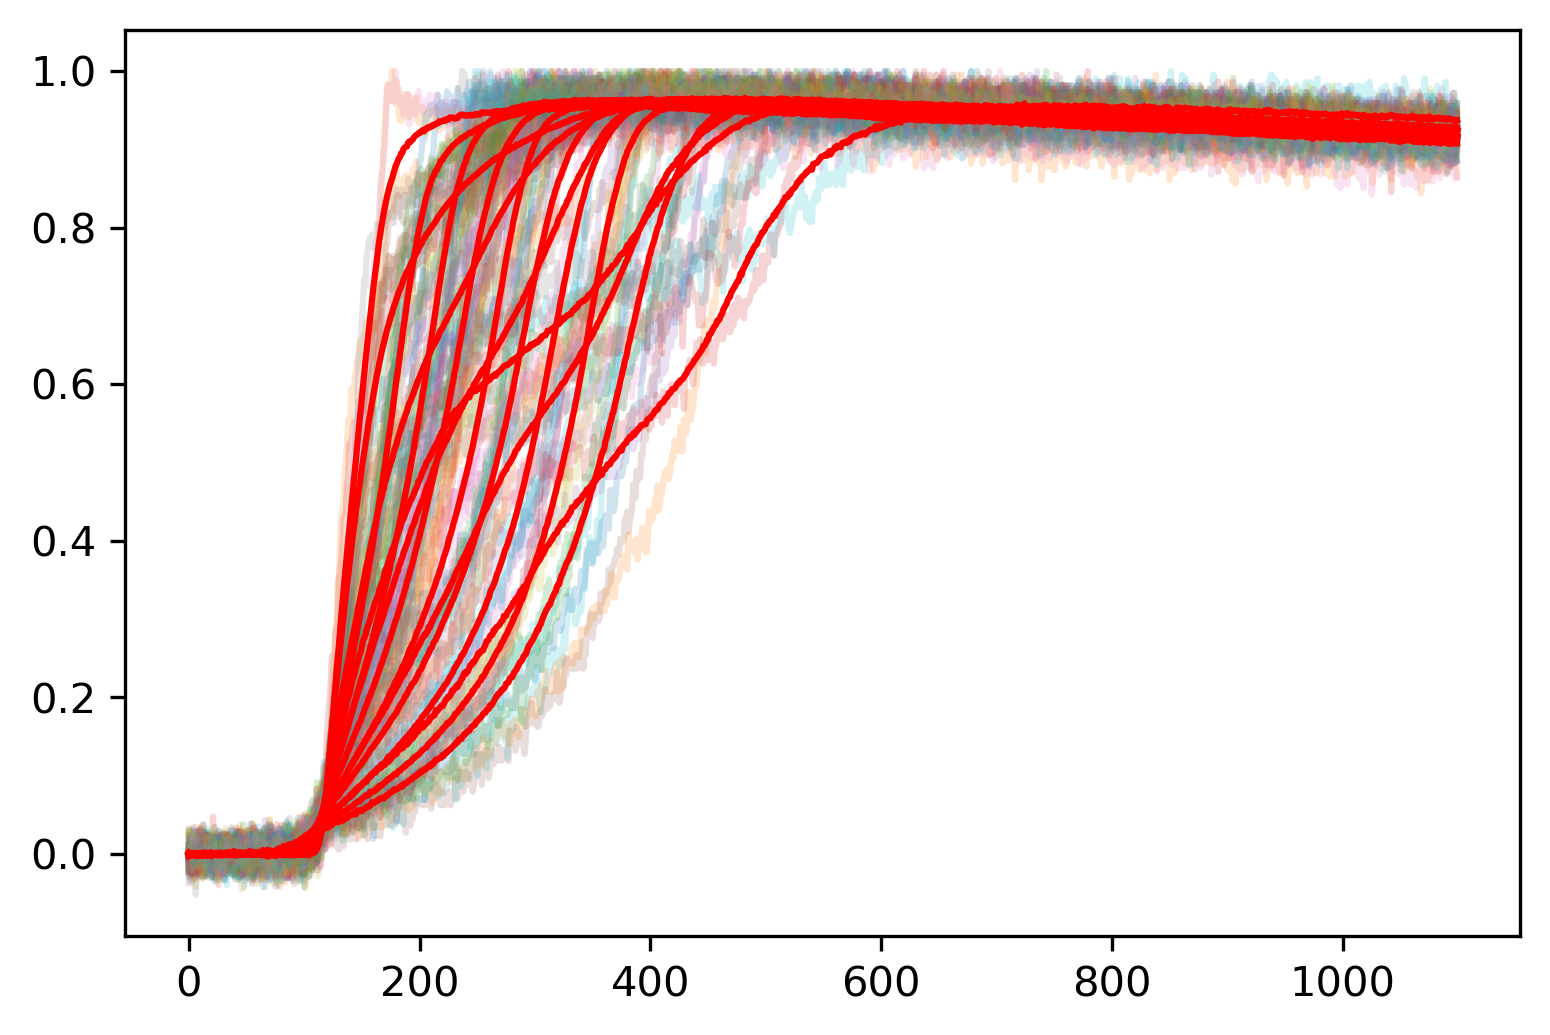

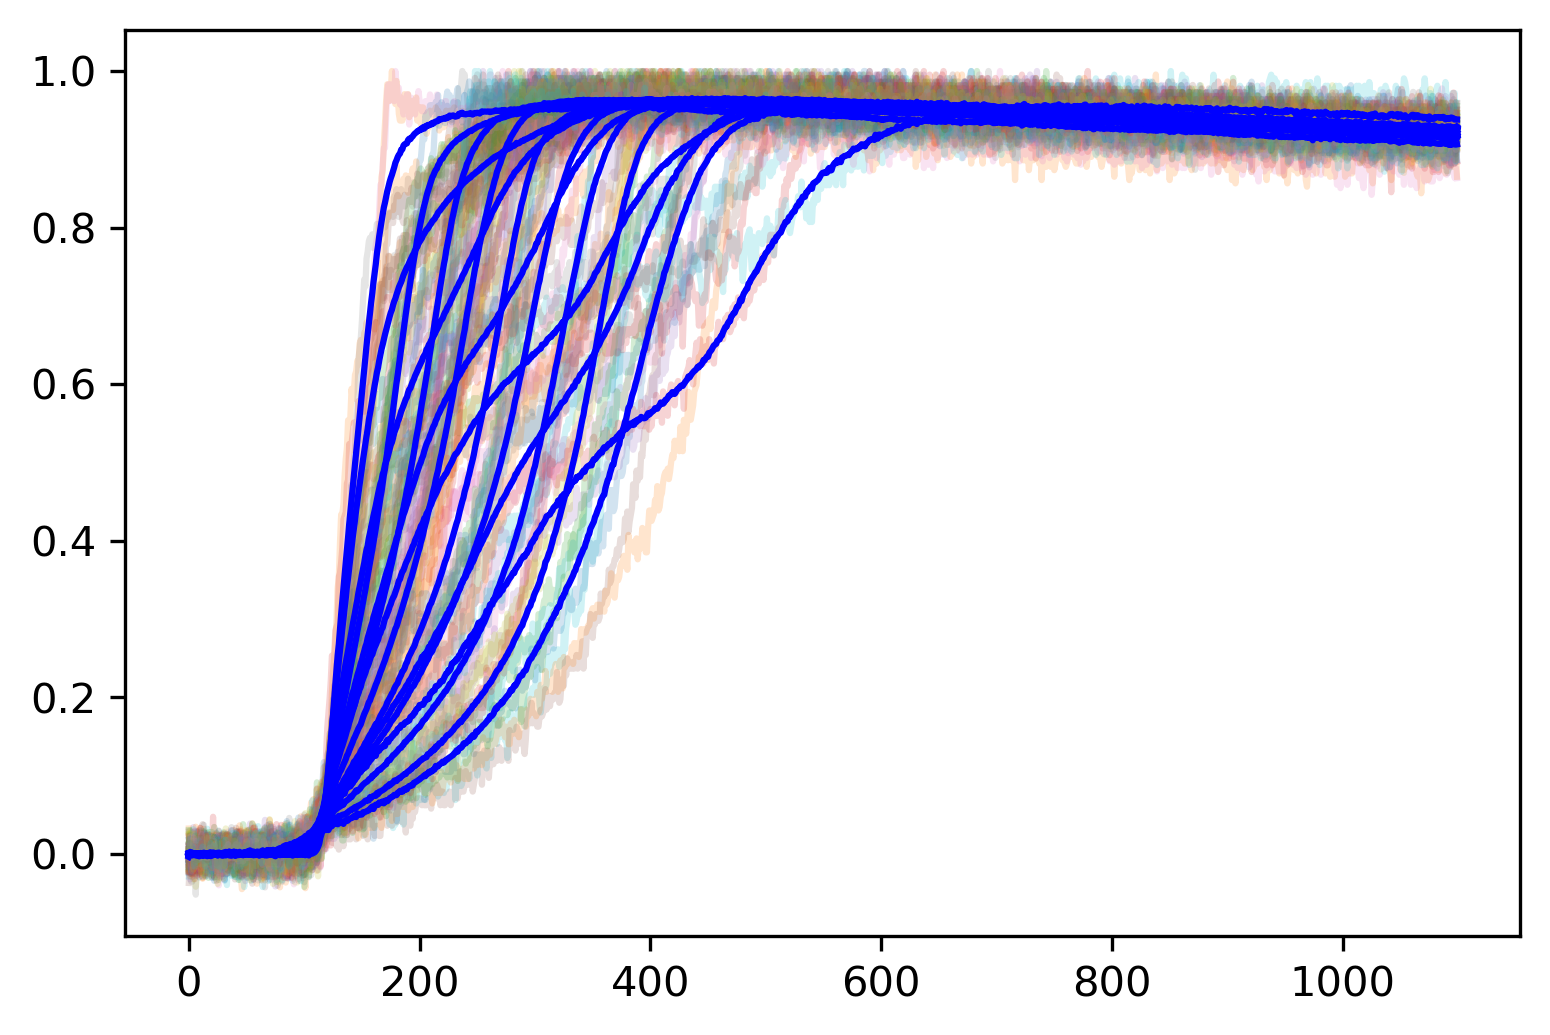

In [46]:
for i in range(100):
    plt.plot(cs_photopeak_zero[i], alpha=0.2)
for k in range(n):
    plt.plot(gmm.means_[k], color='red') #, alpha=0.5)
plt.show()
    
for i in range(100):
    plt.plot(cs_photopeak_zero[i], alpha=0.2)
for k in range(n):
    plt.plot(kmeans.cluster_centers_[k], color='blue') #, alpha=0.5)
    
plt.show()

Text(0.5, 1.0, '15 Clusters\nRed = Gaussian Mixture\nBlue = K Means')

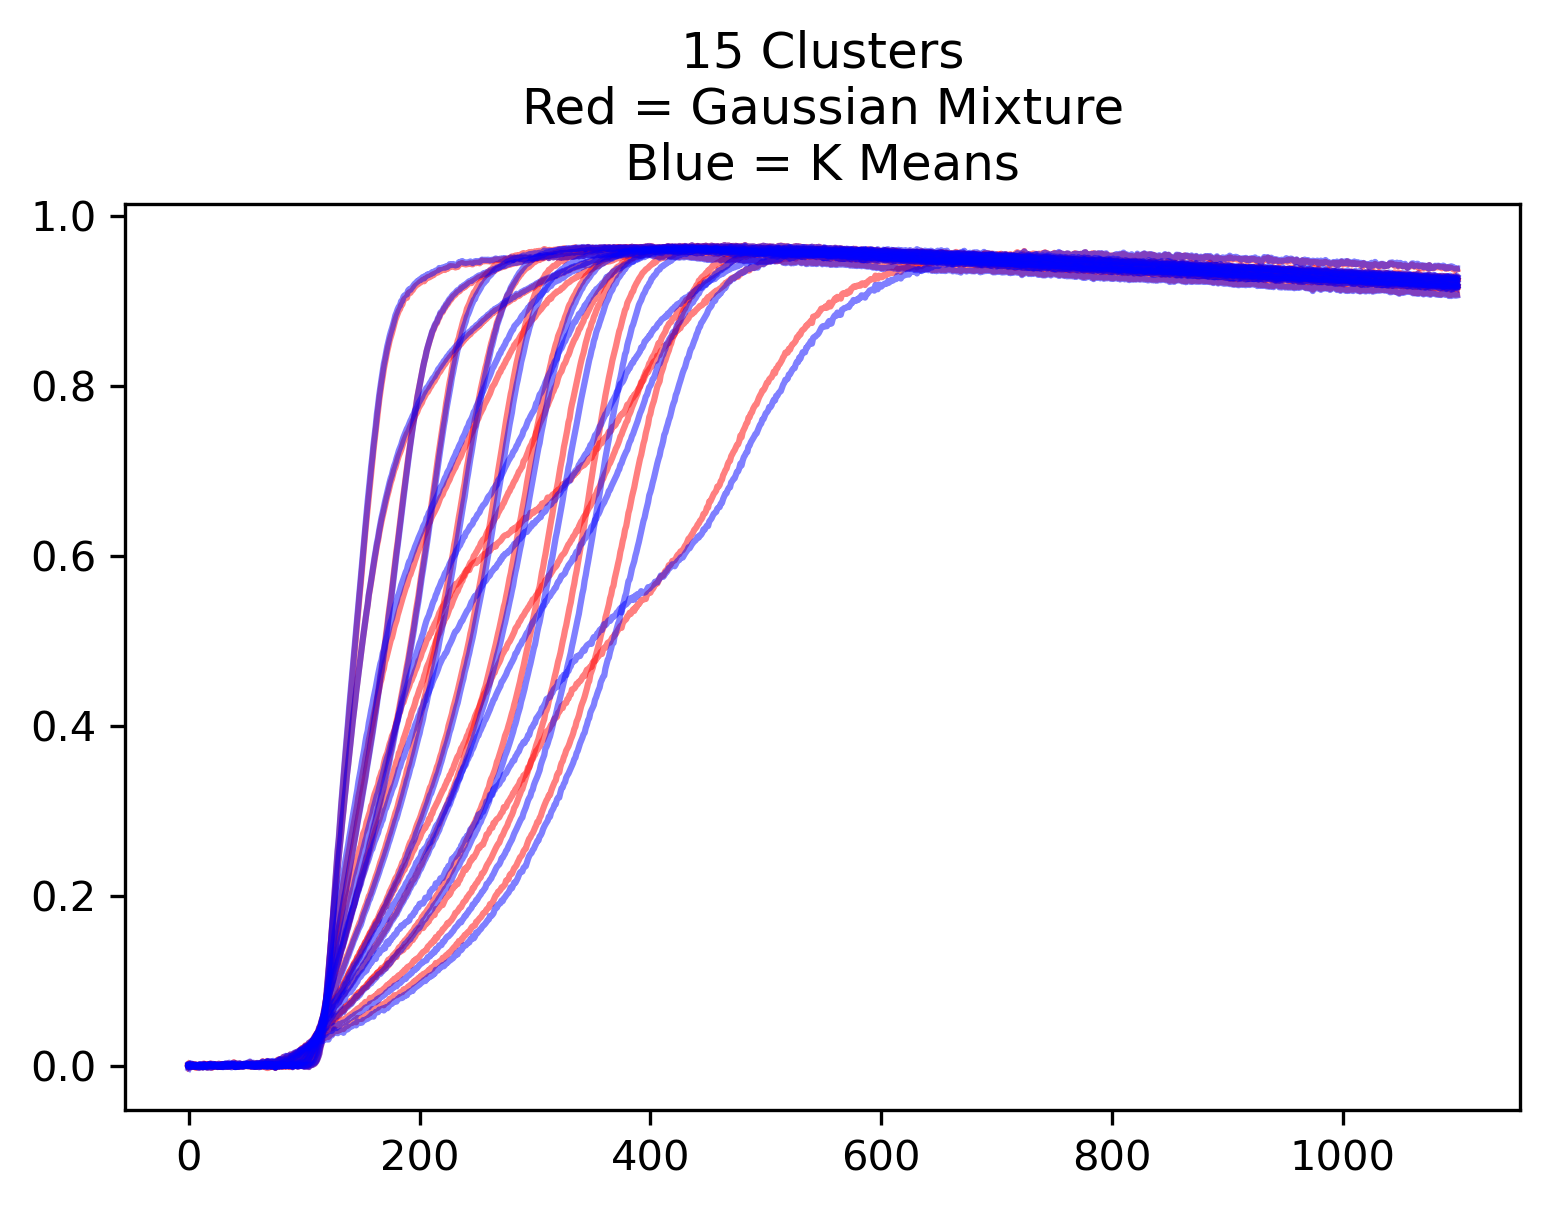

In [43]:
for k in range(n):
    plt.plot(gmm.means_[k], color='red', alpha=0.5)
for k in range(n):
    plt.plot(kmeans.cluster_centers_[k], color='blue', alpha=0.5)
plt.title('{} Clusters\nRed = Gaussian Mixture\nBlue = K Means'.format(n))

In [45]:
gmm.converged_

True

In [47]:
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter

In [88]:
rise_times = []
for pp in range(len(cs_photopeak_zero)):
    signal = savgol_filter(cs_photopeak_zero[pp], 31, 0)
    rise_times.append(CFD(signal, 0.9, samp_size=50)-CFD(signal, 0.1, samp_size=50))

In [198]:
n = 250
kmeans = KMeans(init="random",n_clusters=n, n_init=10,
    max_iter=2000,random_state=42)

kmeans.fit(cs_photopeak_zero)

KMeans(init='random', max_iter=2000, n_clusters=250, random_state=42)

In [293]:
def cluster_data(data, n_clust, quality=True, buff=50):
    kmeans = KMeans(init='random', n_clusters=n_clust, n_init=10, max_iter=2000, random_state=int(time.time()))
    kmeans.fit(data)
    
    clusts = kmeans.labels_
    
    rise_times = []
    for pp in range(len(data)):
        signal = savgol_filter(data[pp], 31, 0)
        rise_times.append([CFD(signal, 0.1, samp_size=50), CFD(signal, 0.9, samp_size=50)])
    
    if quality:
        chisq = []
        for i in range(len(clusts)):
            weight = np.zeros(len(cs_photopeak_zero[i]))
            weight[rise_times[i][0]:rise_times[i][1]+buff] = np.ones((rise_times[i][1]+buff)-(rise_times[i][0]))
            weight = weight/sum(weight)
            #sst = np.cumsum(np.square(data[i]-np.mean(data[i])))[-1]
            val = np.sum(weight*np.abs((data[i]-kmeans.cluster_centers_[kmeans.labels_[i]])/kmeans.cluster_centers_[kmeans.labels_[i]]))
            #sse = np.cumsum(np.square(data[i]-kmeans.cluster_centers_[kmeans.labels_[i]])/kmeans.cluster_centers_[kmeans.labels_[i]])[-1]
            chisq.append(val)

        return np.array(chisq)

In [296]:
chi = cluster_data(cs_photopeak_zero, 250)

In [297]:
chi

array([0.04590039, 0.05190482, 0.05101846, ..., 0.03911477, 0.03355645,
       0.03694944])

  0%|          | 0/250 [00:00<?, ?it/s]

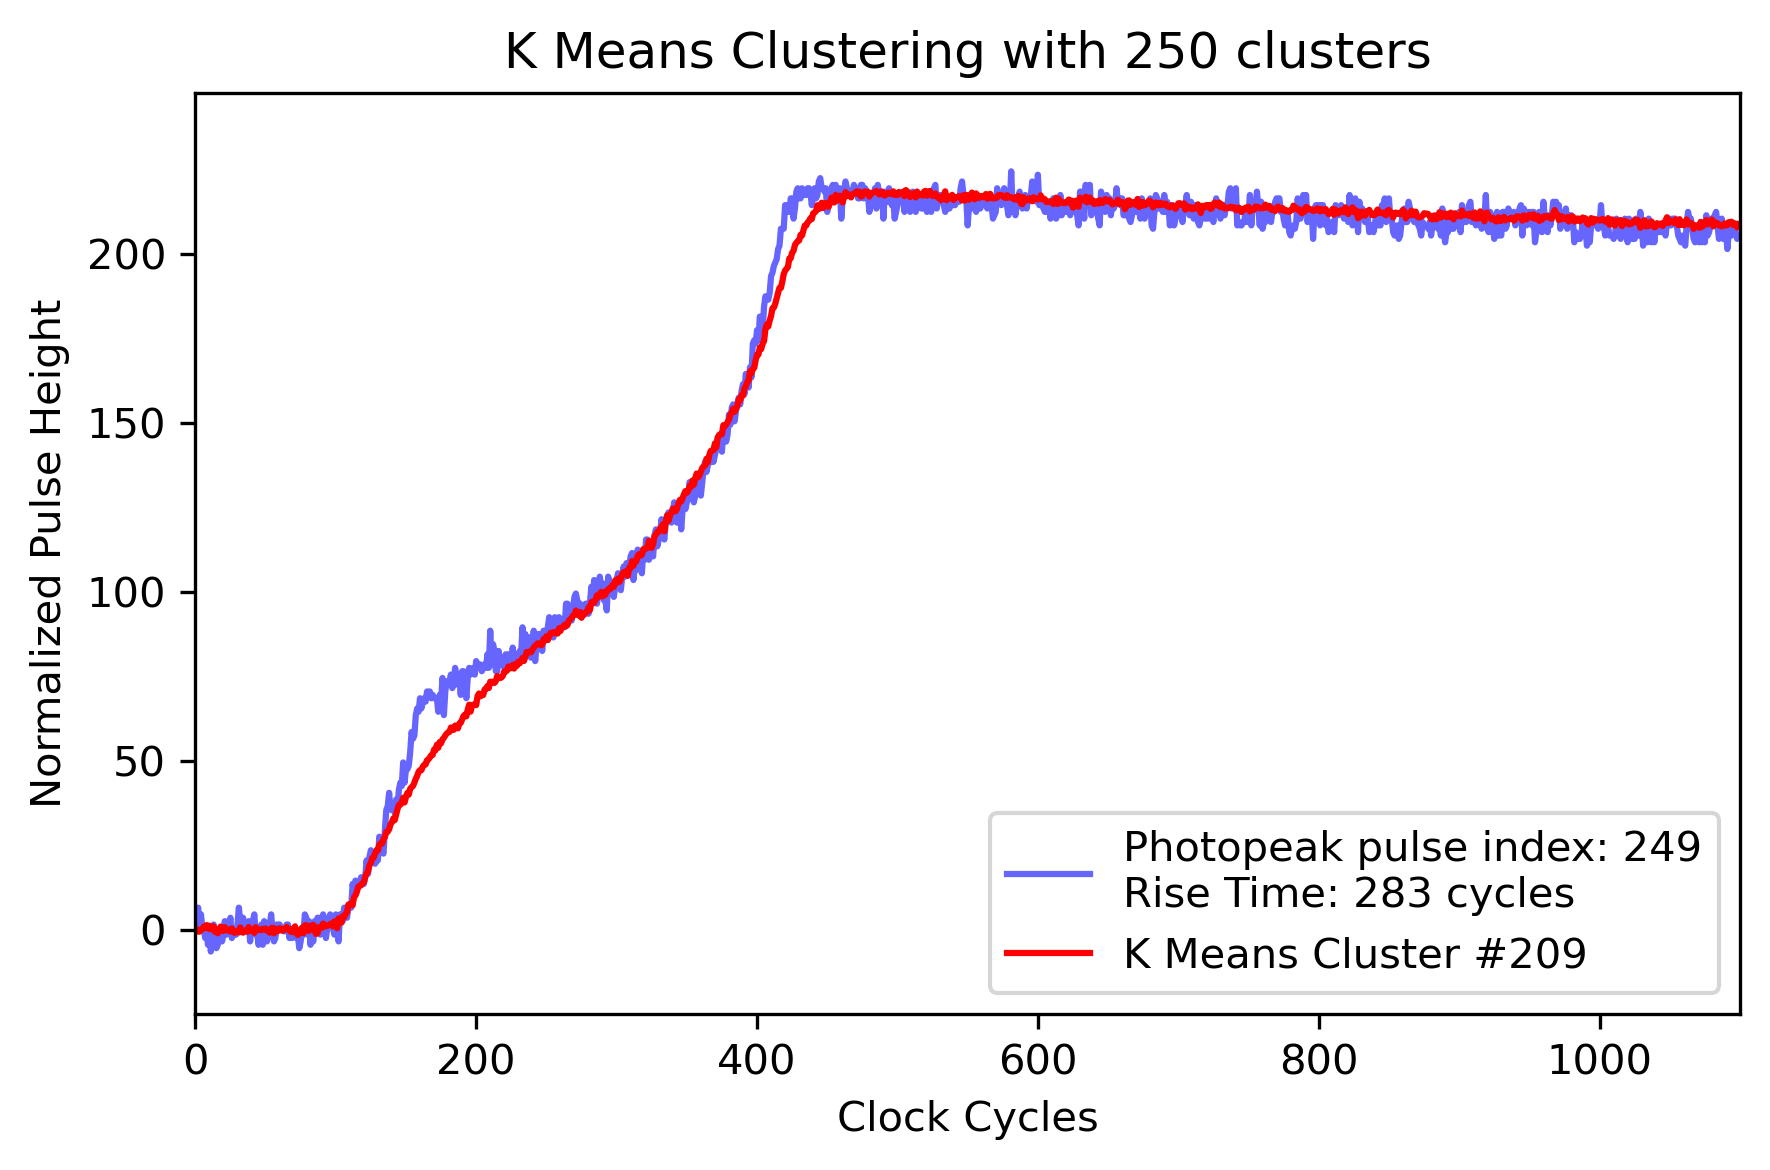

In [146]:
fig = plt.figure(dpi=300)
ax = fig.gca()

legend = ax.legend([''])

pulse = ax.plot([], [], color='blue', alpha=0.6)
mean = ax.plot([], [], color='red')

plots = [pulse, mean]

def init_plot():
    # Chemical Spectra subplot init
    ax.set_xlim(0, len(cs_photopeak_zero[0]))
    ax.set_ylim(-25, np.max(cs_photopeak_zero)+10)
    ax.set_xlabel('Clock Cycles')
    ax.set_ylabel('Normalized Pulse Height')
    ax.set_title('K Means Clustering with {} clusters'.format(n))
    #ax.xaxis.set_minor_locator(MultipleLocator(10))
    #ax.grid(which='major')
    #ax.grid(which='minor', linestyle='--', alpha=0.2)
    #ax.set_aspect('auto')
    fig.tight_layout()
    return plots

def animate(fr, legend, photopeak, kmeans, rise_times):
    #print(plots[0][0])
    plots[0][0].set_data(np.arange(len(photopeak[fr])), photopeak[fr])
    plots[0][0].set_label('Photopeak pulse index: {}\nRise Time: {} cycles'.format(fr, rise_times[fr]))
    
    plots[1][0].set_data(np.arange(len(kmeans.cluster_centers_[kmeans.labels_[fr]])), kmeans.cluster_centers_[kmeans.labels_[fr]])
    plots[1][0].set_label('K Means Cluster #{}'.format(kmeans.labels_[fr]))
    
    legend.remove()
    legend = ax.legend(loc='lower right', fontsize=10)
    
    return plots + [legend]
    
metadata = dict(title='K Means Animation', artist='Chris Lamb', comment='Just interact in the same place')

frames = 250
fps = 5

ani = animation.FuncAnimation(fig, animate, init_func=init_plot, frames=tqdm(range(frames), leave=True),
                                  fargs=(legend, cs_photopeak_zero, kmeans, rise_times))
FFwriter = animation.FFMpegWriter(fps=fps, metadata=metadata)
ani.save('Plots/K_means_{}clusters_Cs137_PP.mp4'.format(n), writer=FFwriter)

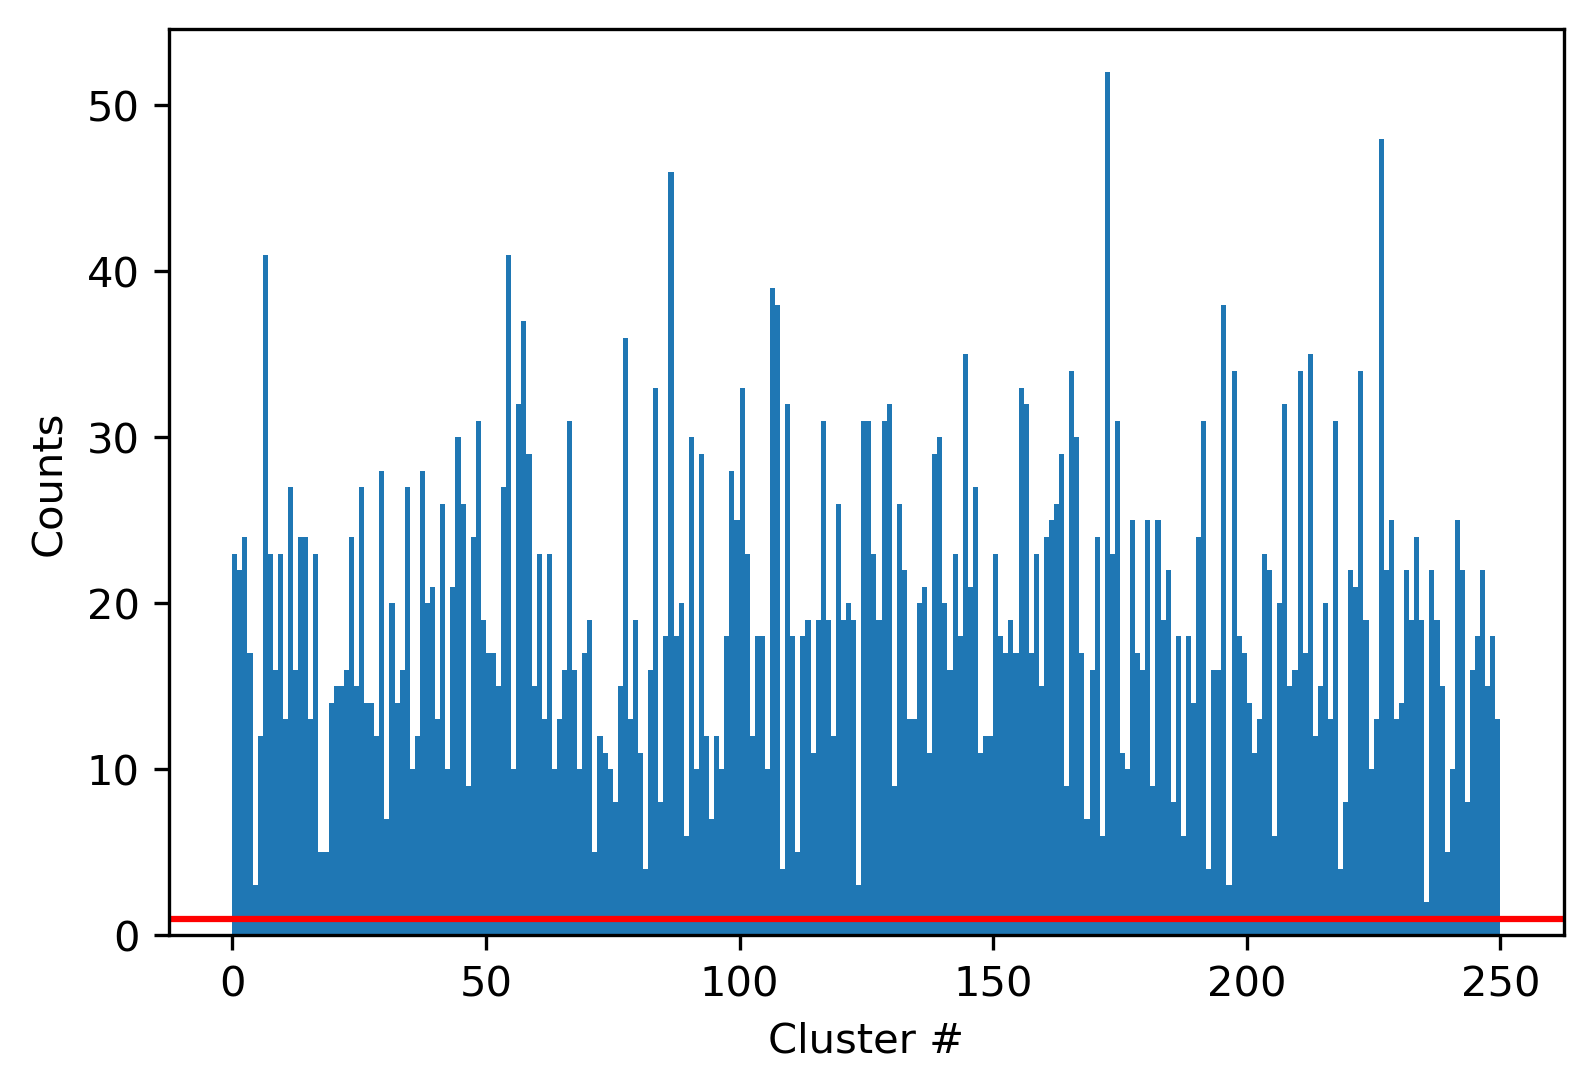

In [147]:
plt.hist(kmeans.labels_, bins=np.arange(n+1))
plt.axhline(1, color='r')
plt.ylabel('Counts')
plt.xlabel('Cluster #')
plt.show()

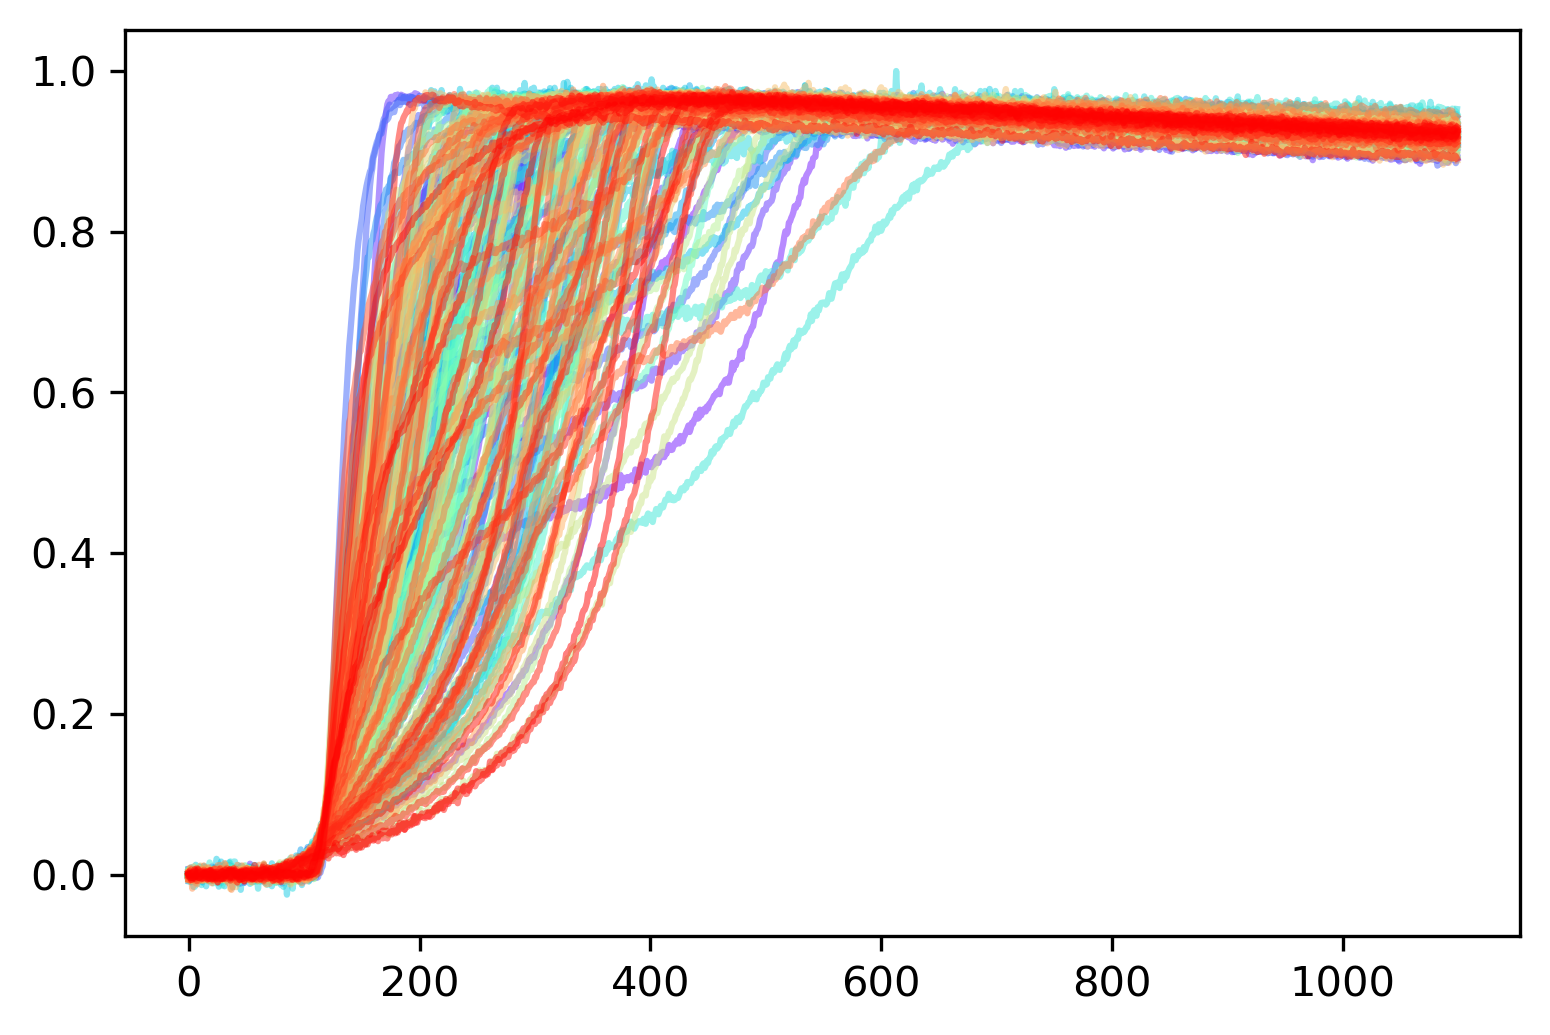

In [123]:
cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, n))

for k in range(n):
    plt.plot(kmeans.cluster_centers_[k], color=colors[k], alpha=0.5)

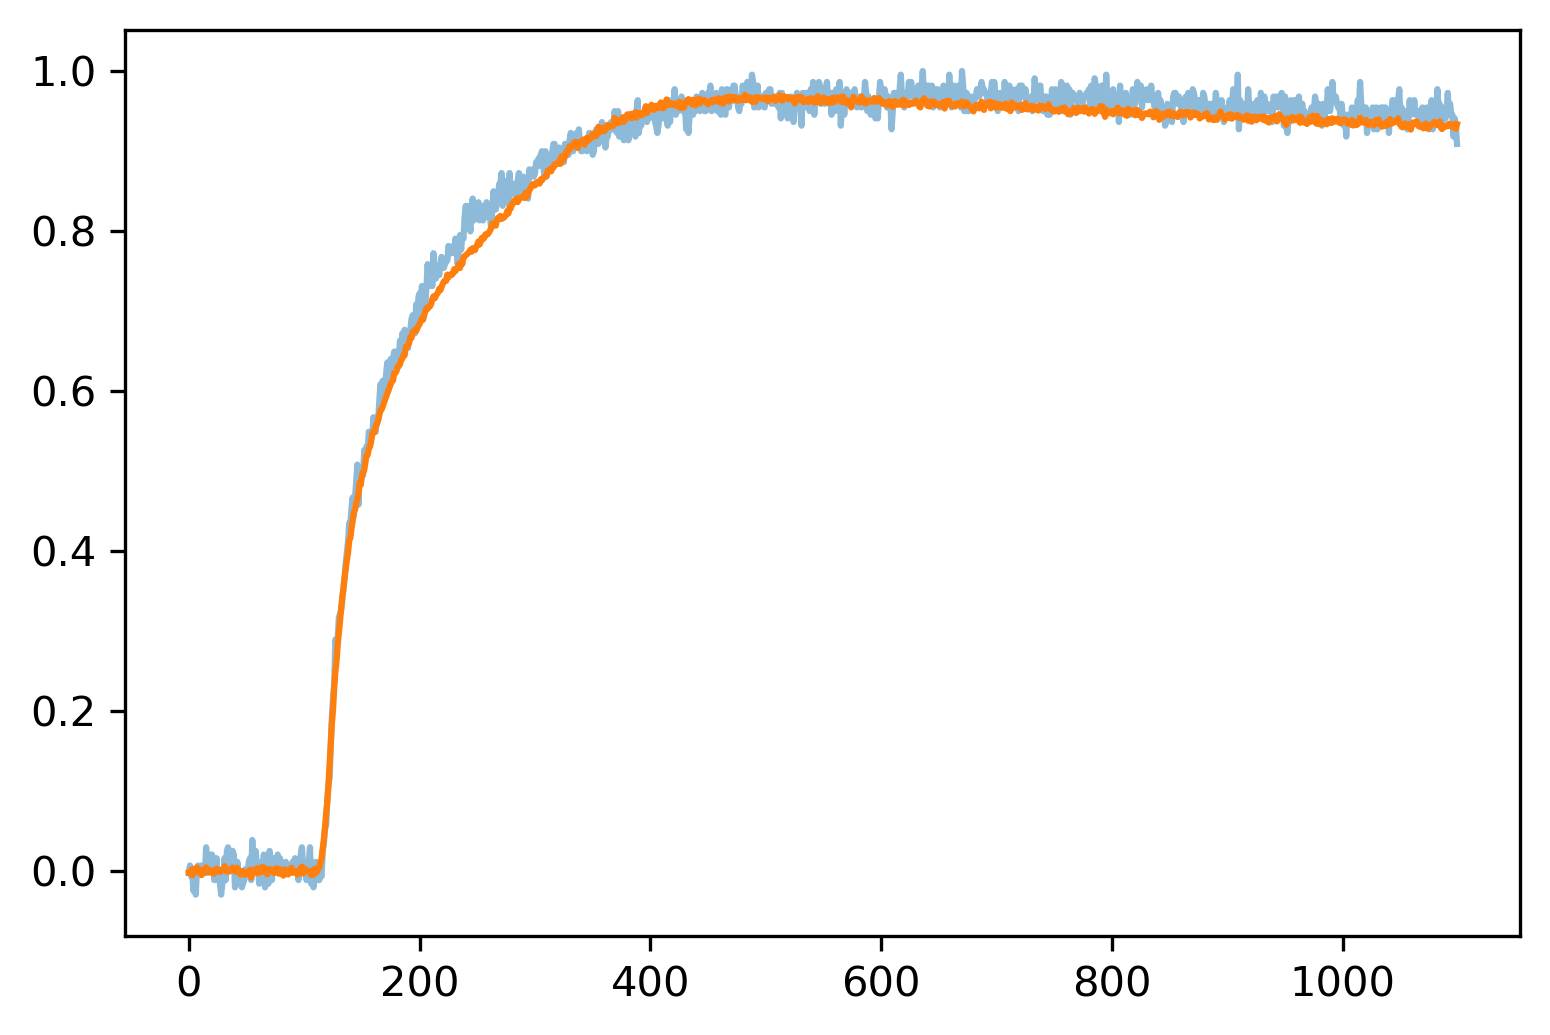

In [302]:
i = np.argmin(chi)
plt.plot(cs_photopeak_zero[i], alpha=0.5)
plt.plot(kmeans.cluster_centers_[kmeans.labels_[i]])
#plt.plot(cs_photopeak_zero[i]-kmeans.cluster_centers_[kmeans.labels_[i]])

In [208]:
np.argmax(rs)

2191

In [195]:
i = 0
sst = np.cumsum(np.square(cs_photopeak_zero[i]-np.mean(cs_photopeak_zero[i])))[-1]
sse = np.cumsum(np.square(cs_photopeak_zero[i]-kmeans.cluster_centers_[kmeans.labels_[i]]))[-1]

r = 1-sse/sst

In [196]:
r

0.9979855242267582

In [182]:
(cs_photopeak_zero[i]-np.mean(cs_photopeak_zero[i]))[:2]

array([-0.76955109, -0.75635036])

In [183]:
sum((cs_photopeak_zero[i]-np.mean(cs_photopeak_zero[i]))[:2])

-1.5259014504812256

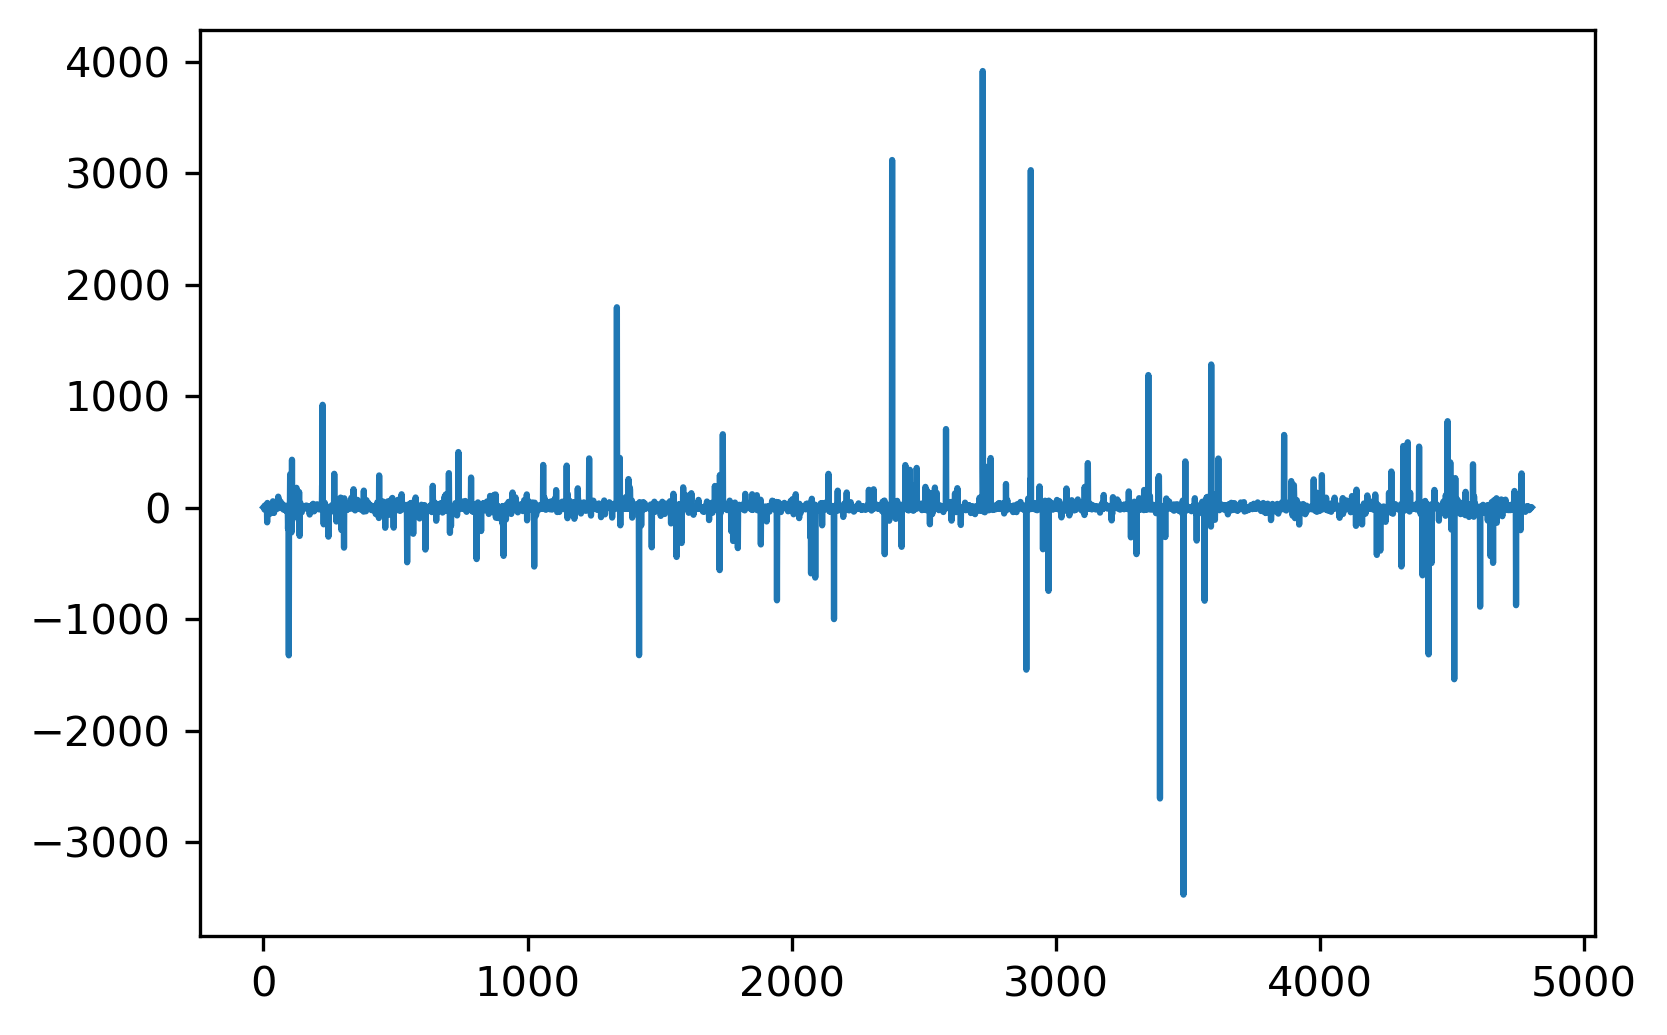

In [213]:
plt.plot(chi)

In [214]:
np.argmax(chi)

2723

In [215]:
np.argmin(rs)

4180

In [216]:
chi2 = cluster_data(cs_photopeak_zero, 2)

In [220]:
np.mean(chi2)

53.776265342935346

In [221]:
np.mean(chi)

3.2298074191253163

In [346]:
chis = []
ns = list(range(2, 302, 2))
for n in tqdm(ns):
    chis.append(np.mean(cluster_data(cs_photopeak_zero, n)))

  0%|          | 0/150 [00:00<?, ?it/s]

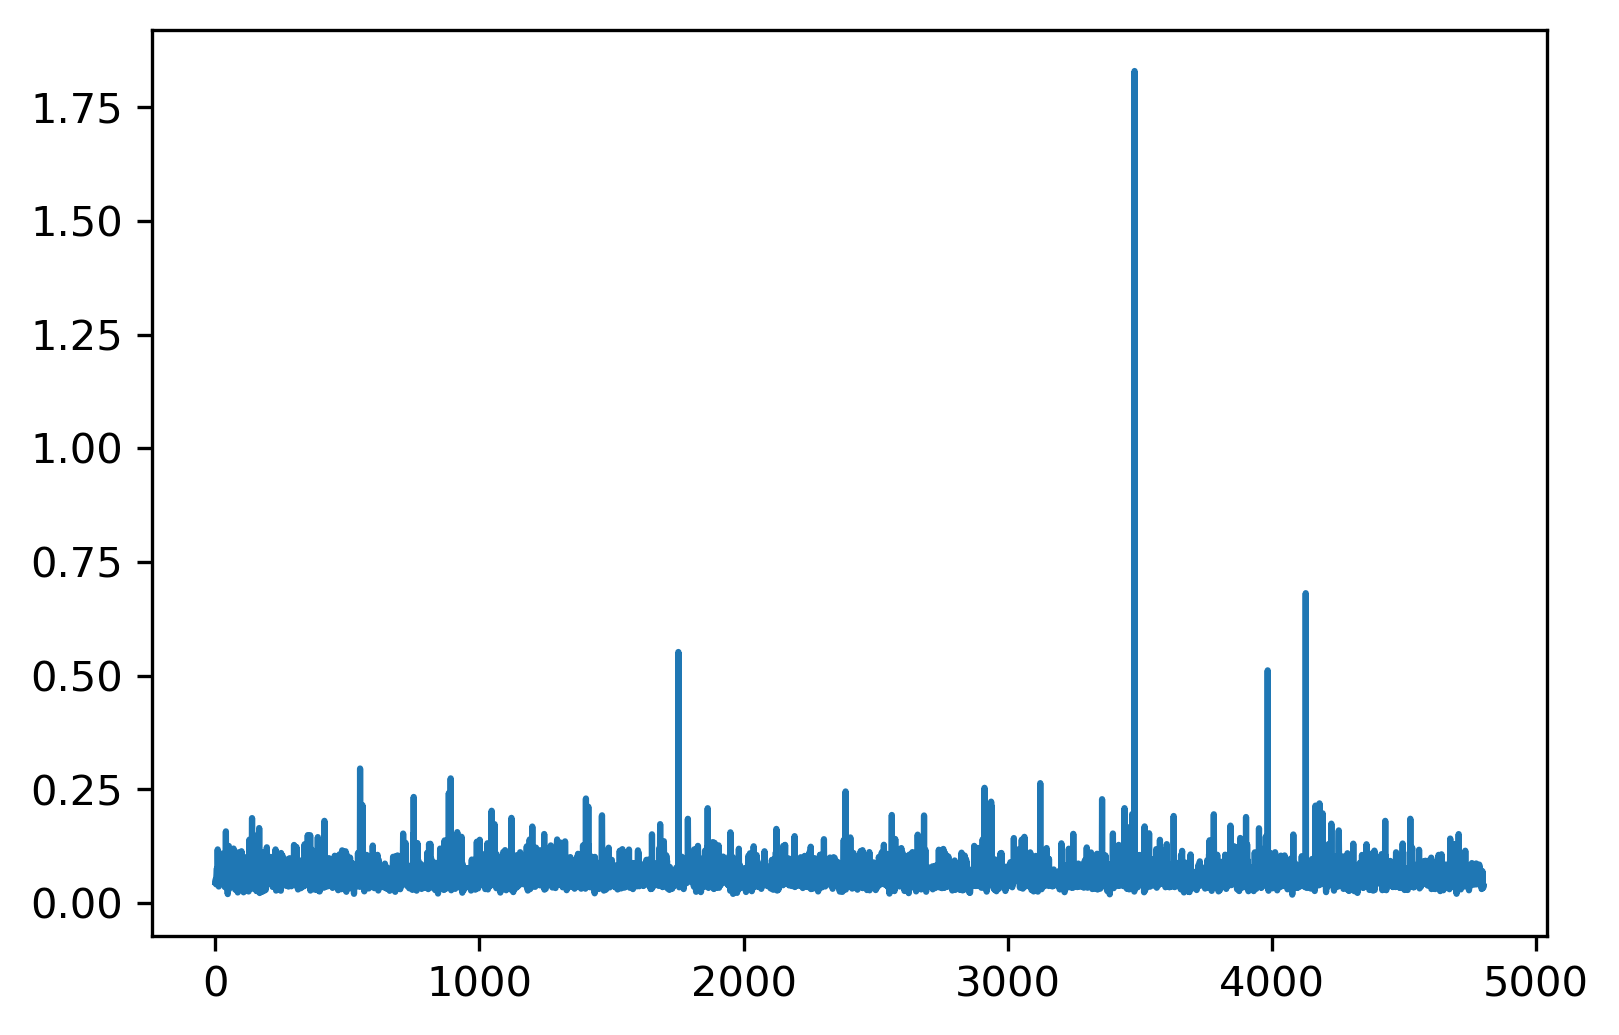

In [298]:
plt.plot(chi)

In [343]:
chis = np.array(chis)

In [344]:
chis = chis[~np.isnan(chis)]

In [345]:
chis

array([0.247905  , 0.20088772, 0.17425693, 0.16620693, 0.15472139,
       0.14618438, 0.14042158, 0.13366242, 0.1278954 , 0.12484982,
       0.12073389, 0.11790297, 0.11596895, 0.11227204, 0.11096724,
       0.10811635, 0.10624831, 0.10559761, 0.10368736, 0.10148268,
       0.10065222, 0.09889448, 0.09760936, 0.09740541, 0.09731242,
       0.09569465, 0.09563012, 0.09409427, 0.09476333, 0.09255694,
       0.09253804, 0.09122306, 0.09072517, 0.09004835, 0.089733  ,
       0.08867066, 0.08846073, 0.08827834, 0.08863829, 0.08706231,
       0.08667257, 0.08617271, 0.08591829, 0.08579891, 0.08475406,
       0.08478923, 0.08358396, 0.08404895, 0.08350548, 0.08273945,
       0.08242532, 0.0818413 , 0.08164681, 0.08192589, 0.08082471,
       0.08080889, 0.08082311, 0.08052582, 0.07939761, 0.08023152,
       0.07860948, 0.07988785, 0.07906009, 0.07916888, 0.07754512,
       0.07759053, 0.07733   , 0.07861587, 0.07738346, 0.07645405,
       0.07623601, 0.07605731, 0.07620823, 0.07545293, 0.07578

In [338]:
def fit_func(x, a, b):
    return a/x+b
curve_fit(fit_func, ns, chis)

ValueError: array must not contain infs or NaNs

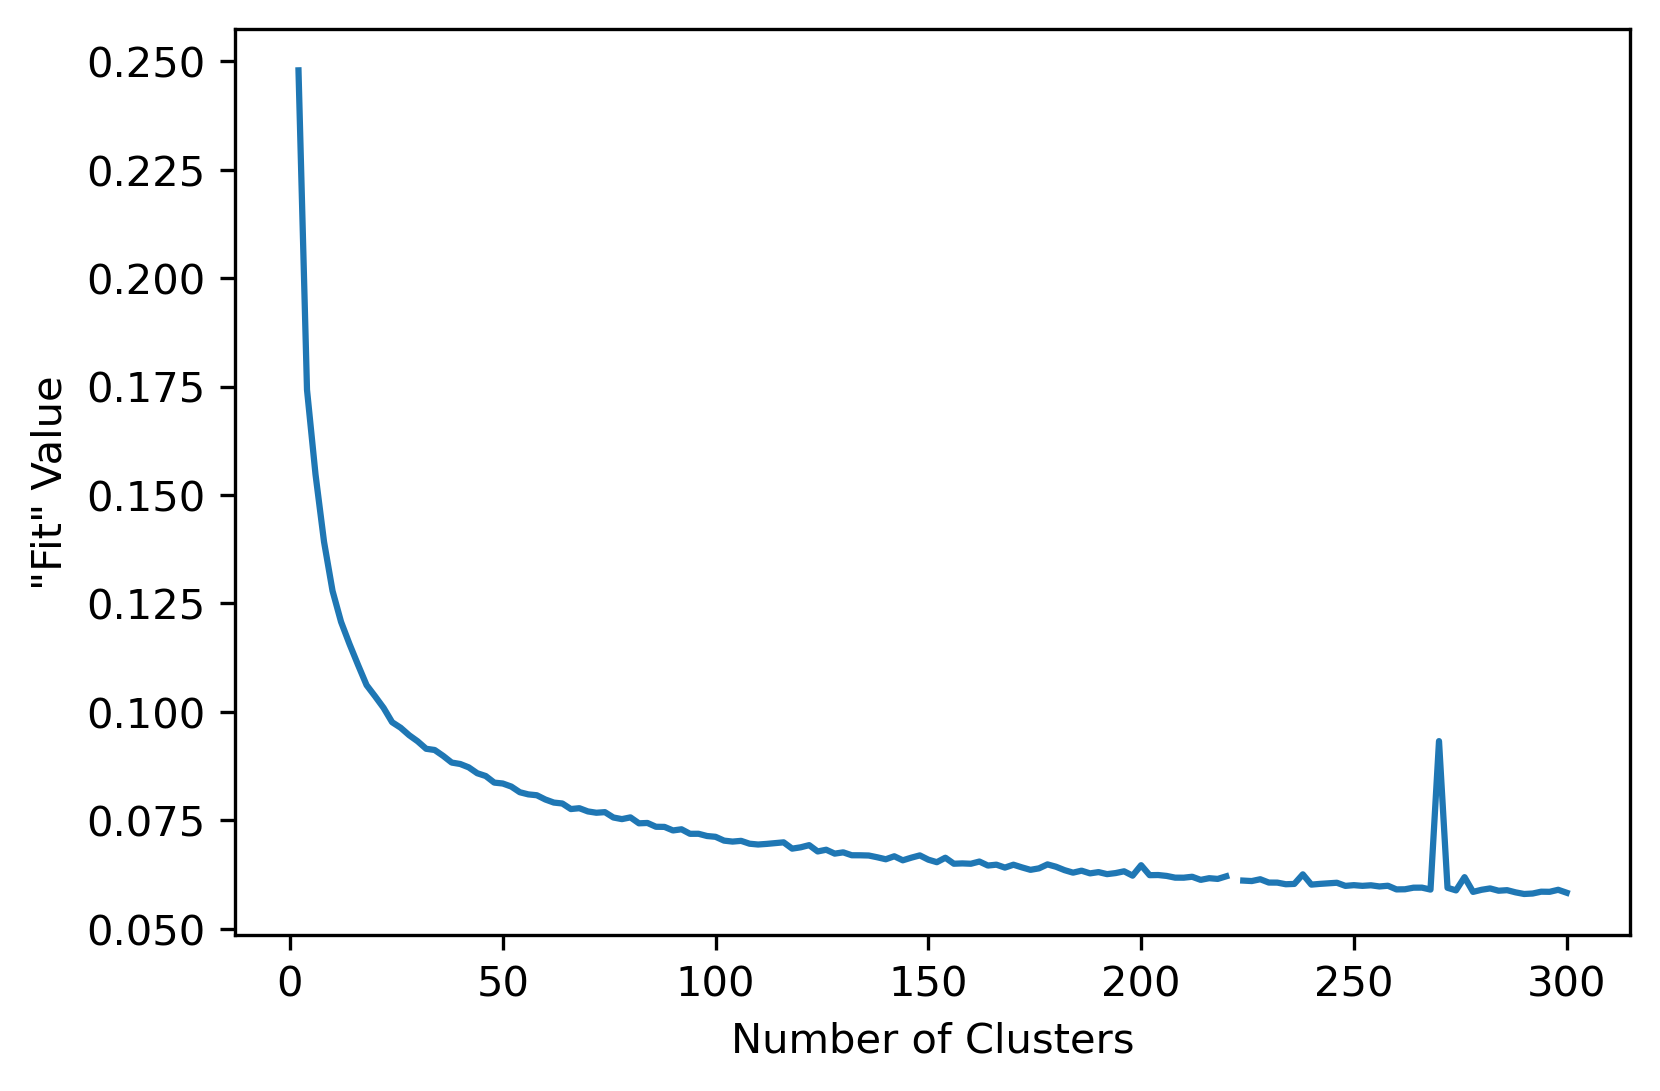

In [347]:
plt.plot(ns, chis)
plt.xlabel('Number of Clusters')
plt.ylabel('"Fit" Value')
#plt.xlim(295, 300)
plt.show()

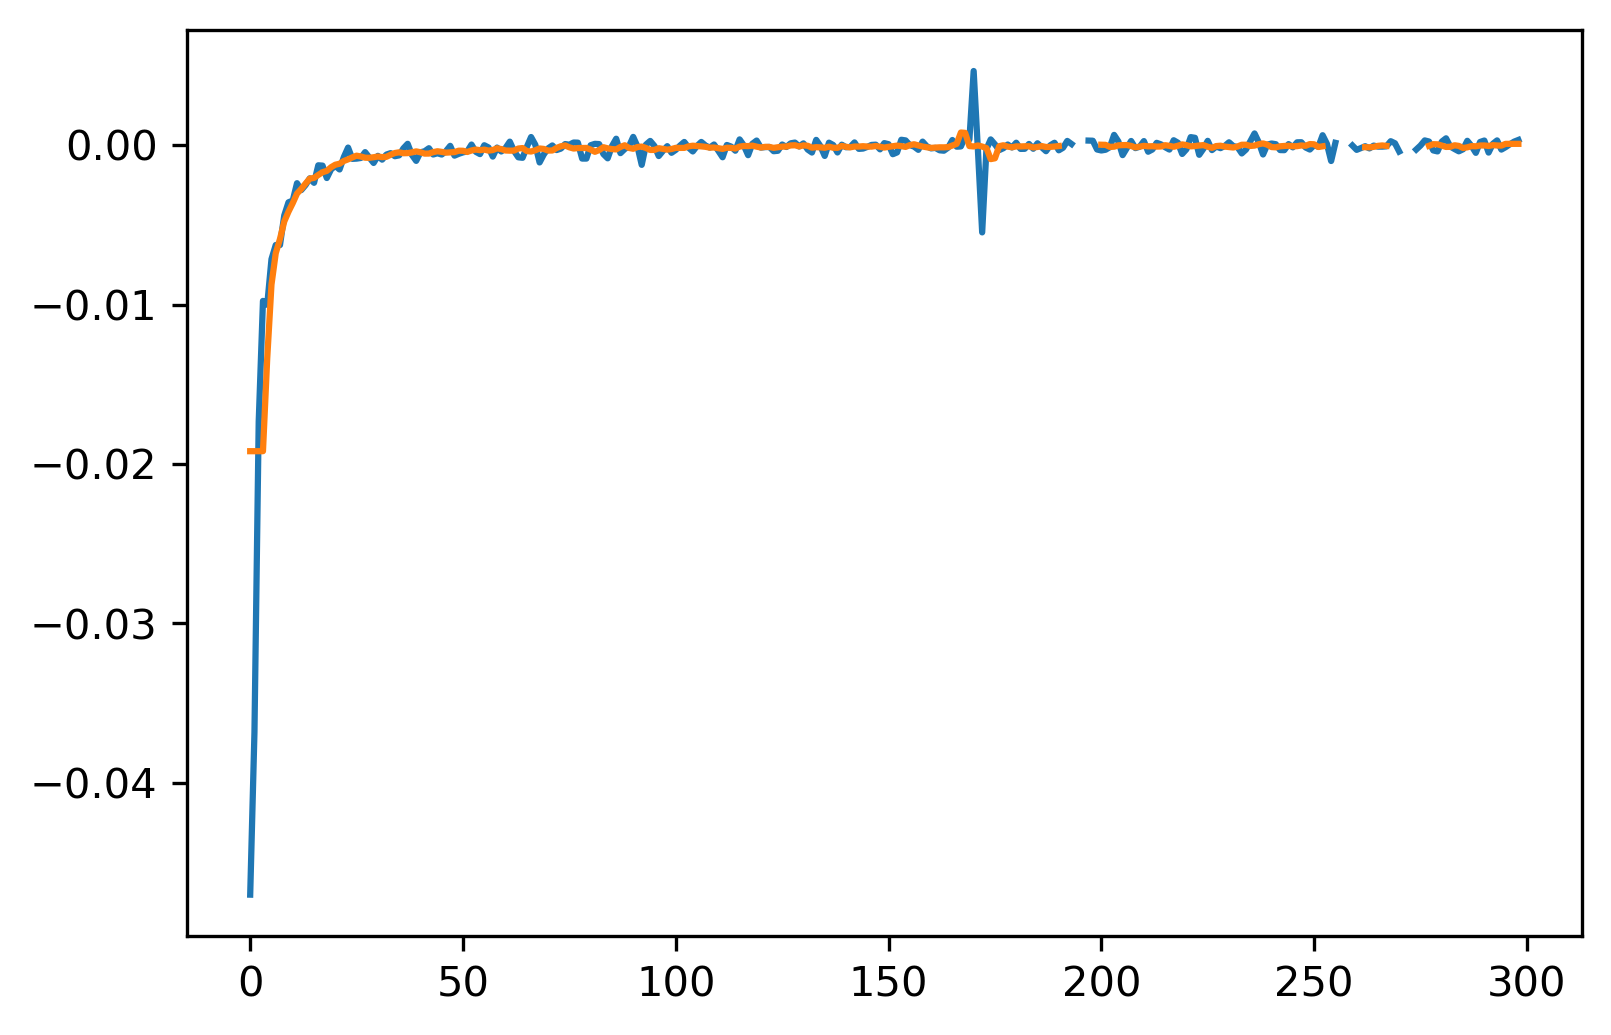

In [336]:
plt.plot(np.gradient(chis))
plt.plot(savgol_filter(np.gradient(chis), 7, 0))

In [229]:
np.where((cs_photopeak_zero[0] >= 0.1) & (cs_photopeak_zero[0] <= 0.9), 1, 0)

array([0, 0, 0, ..., 0, 0, 0])

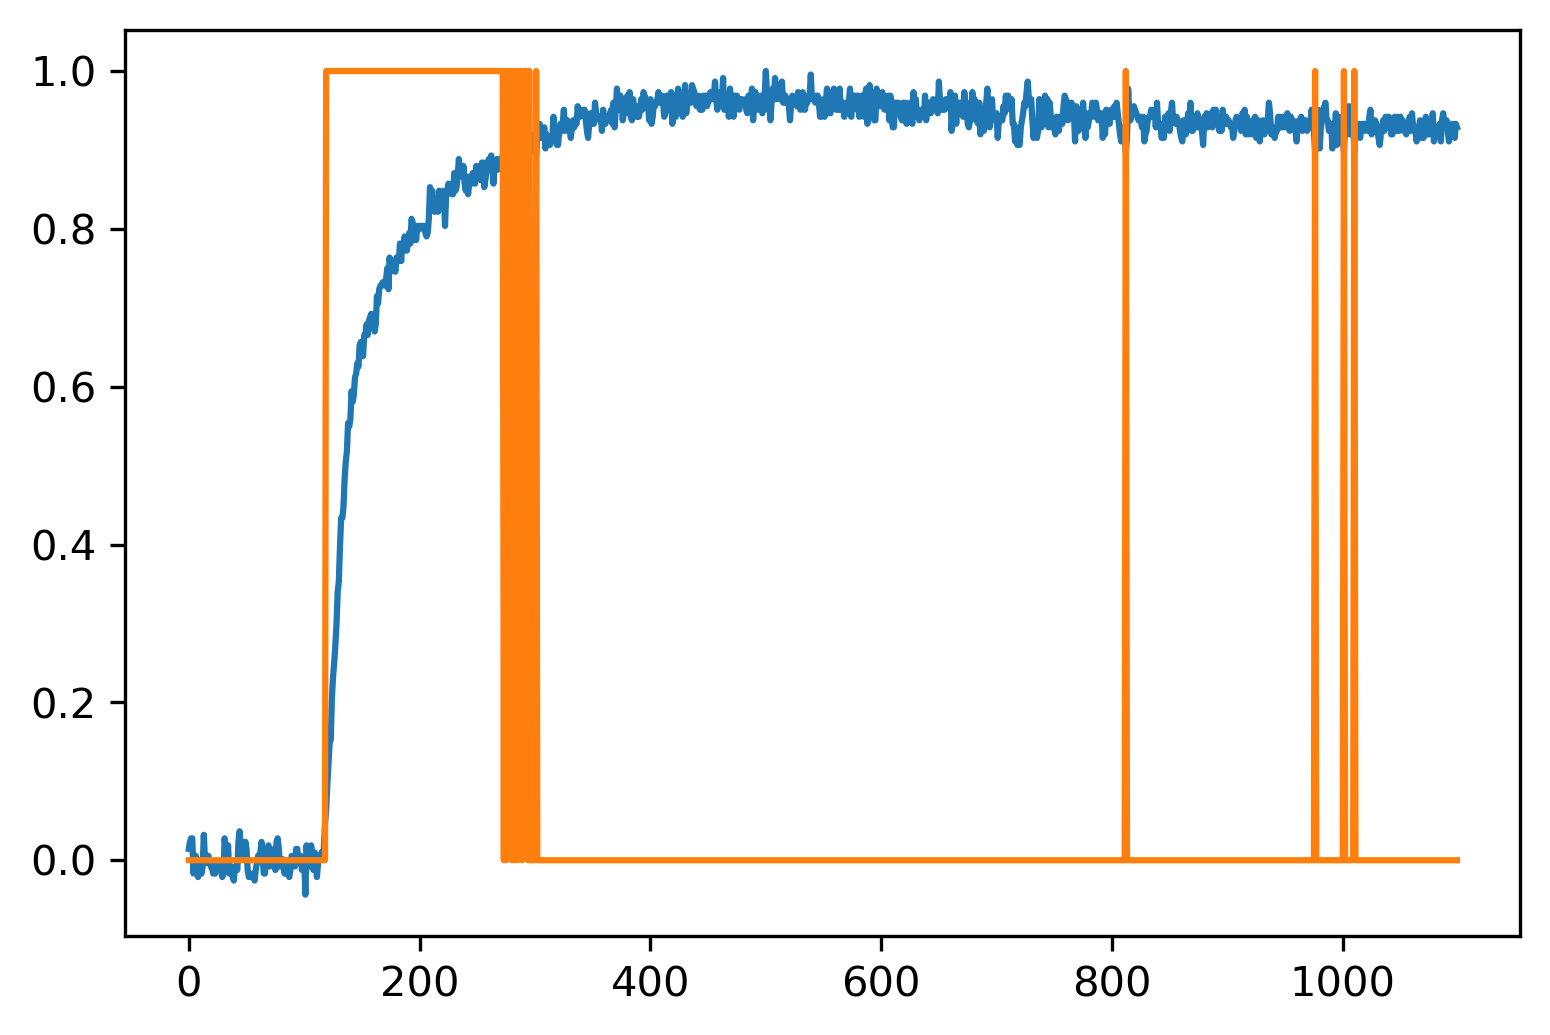

In [233]:
i = 1
plt.plot(cs_photopeak_zero[i])
plt.plot(np.where((cs_photopeak_zero[i] >= 0.05) & (cs_photopeak_zero[i] <= 0.9), 1, 0))

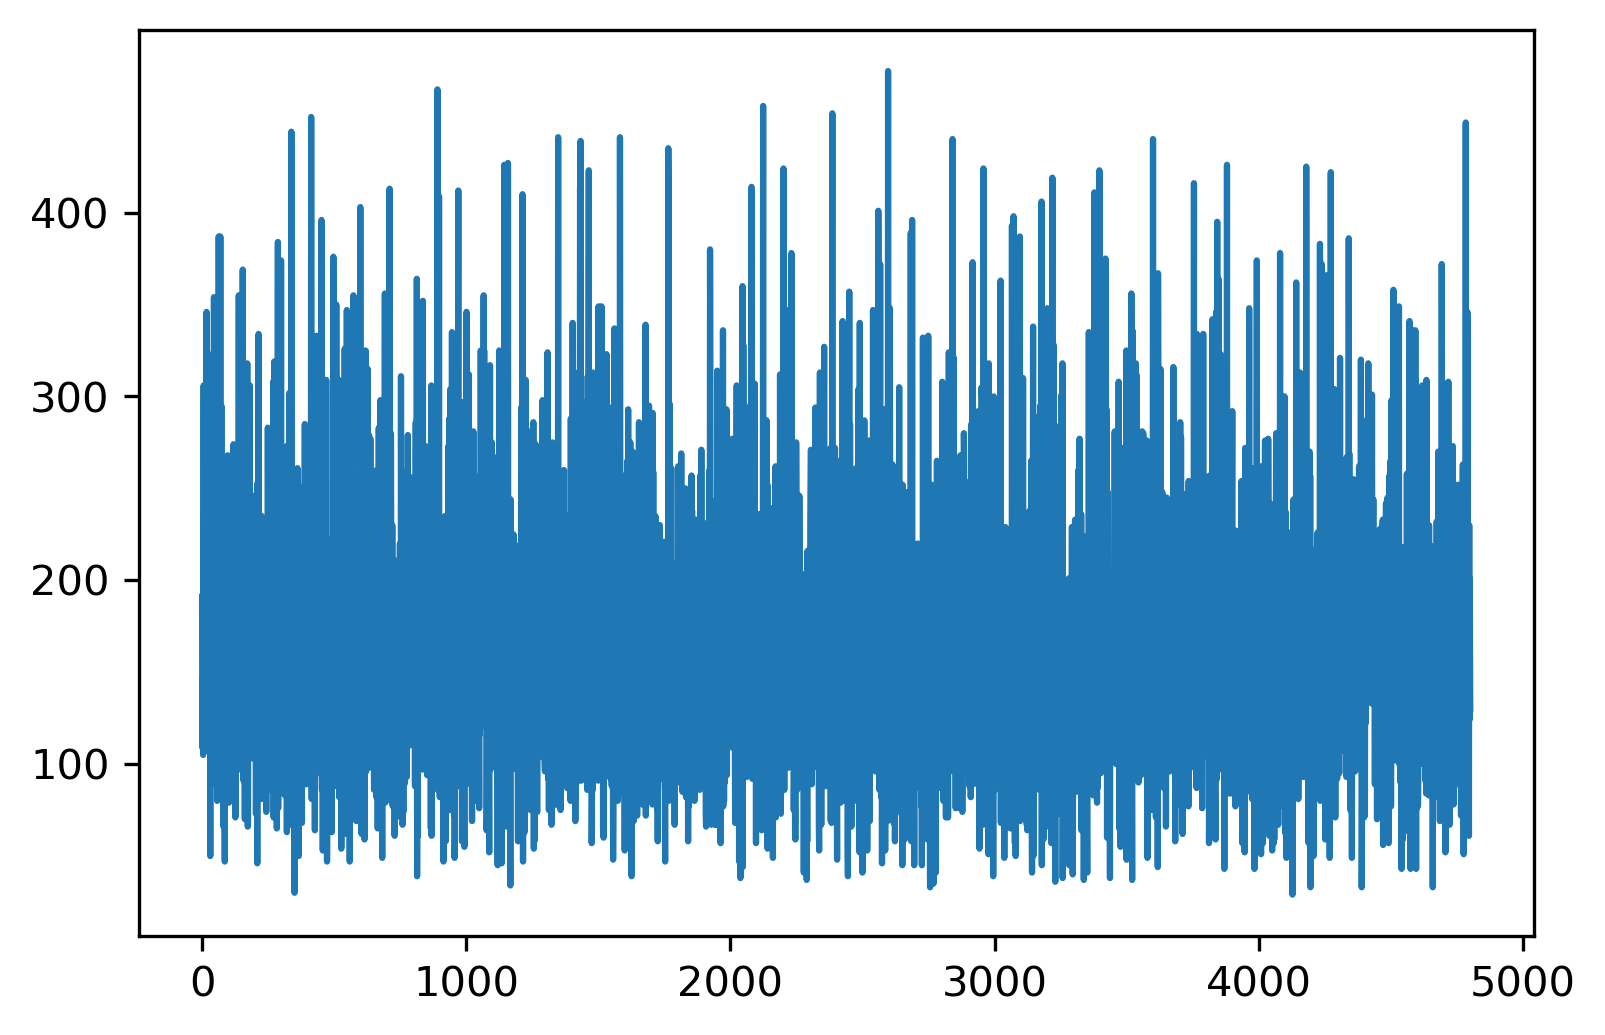

In [247]:
plt.plot(rise_times)

In [250]:
test = np.ones(len(cs_photopeak_zero[0]))*0.1

In [251]:
test[200:400] = np.ones(400-200)*0.9

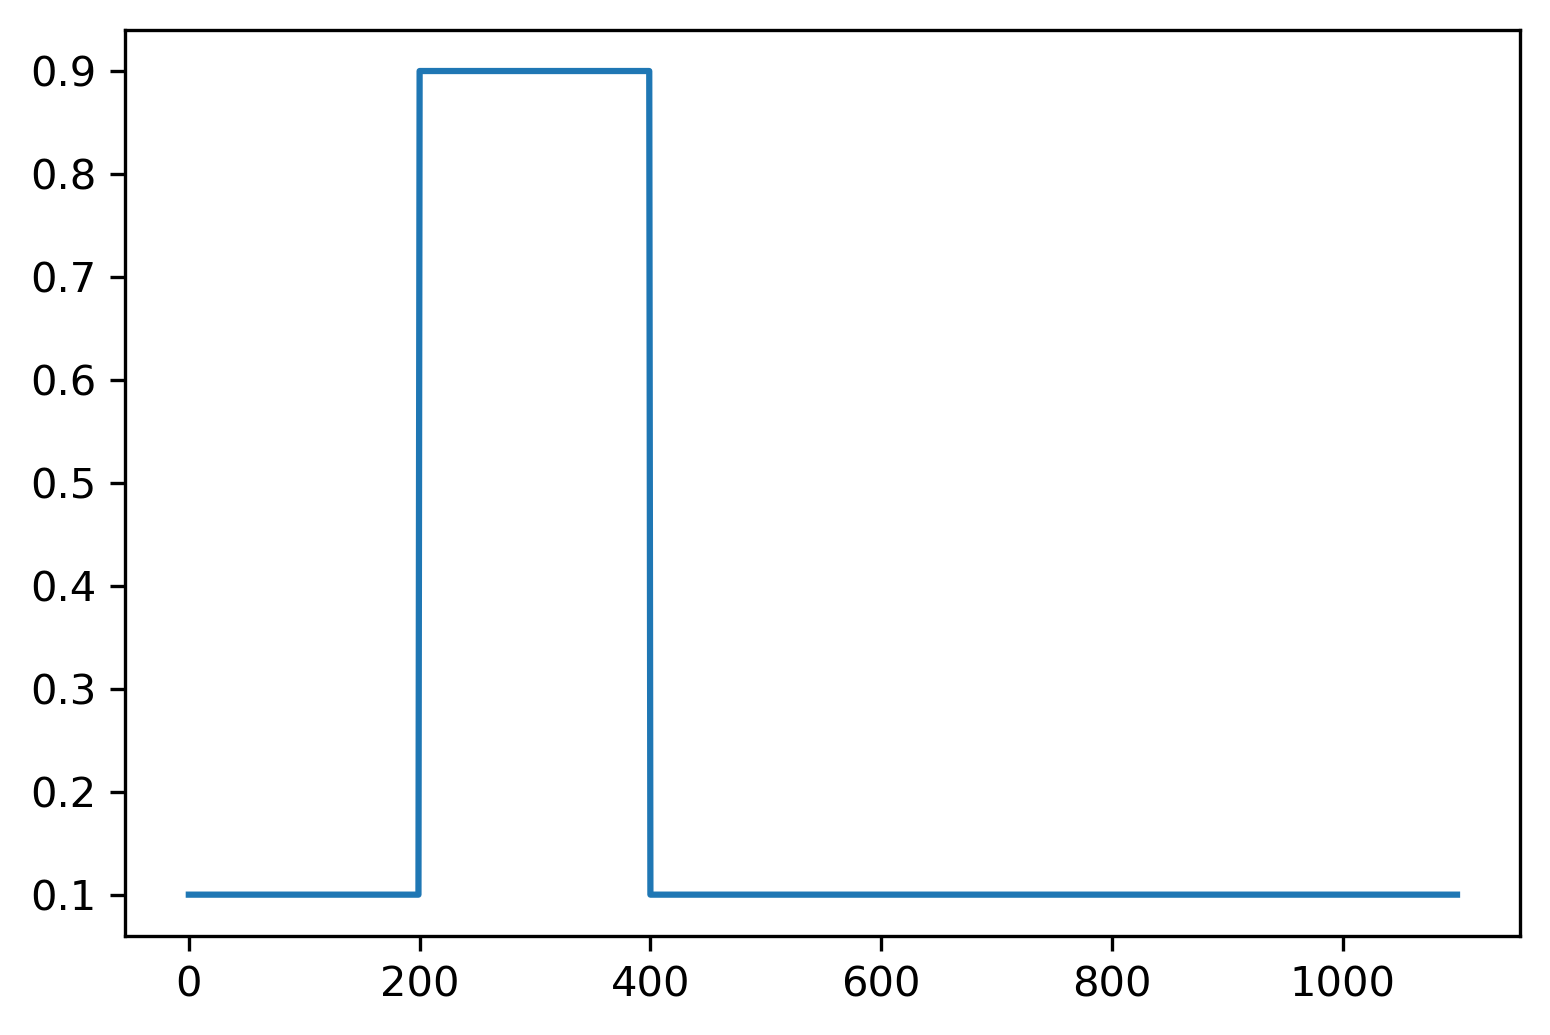

In [252]:
plt.plot(test)

In [258]:
kmeans.

KMeans(init='random', max_iter=2000, n_clusters=250, random_state=42)

In [265]:
i

4801

In [349]:
rise_times = []
for pp in range(len(cs_photopeak_zero)):
    signal = savgol_filter(cs_photopeak_zero[pp], 31, 0)
    rise_times.append([CFD(signal, 0.1, samp_size=50), CFD(signal, 0.9, samp_size=50)])

clusts = kmeans.labels_
#chisq = []
for i in range(len(clusts)):
    weight = np.zeros(len(cs_photopeak_zero[i]))
    weight[rise_times[i][0]:rise_times[i][1]+50] = np.ones((rise_times[i][1]+50)-(rise_times[i][0]))
    #weight = weight/sum(weight)
    #sst = np.cumsum(np.square(data[i]-np.mean(data[i])))[-1]
    val = weight*np.abs((cs_photopeak_zero[i]-kmeans.cluster_centers_[kmeans.labels_[i]])/kmeans.cluster_centers_[kmeans.labels_[i]])
    #sse = np.cumsum(np.square(data[i]-kmeans.cluster_centers_[kmeans.labels_[i]])/kmeans.cluster_centers_[kmeans.labels_[i]])[-1]

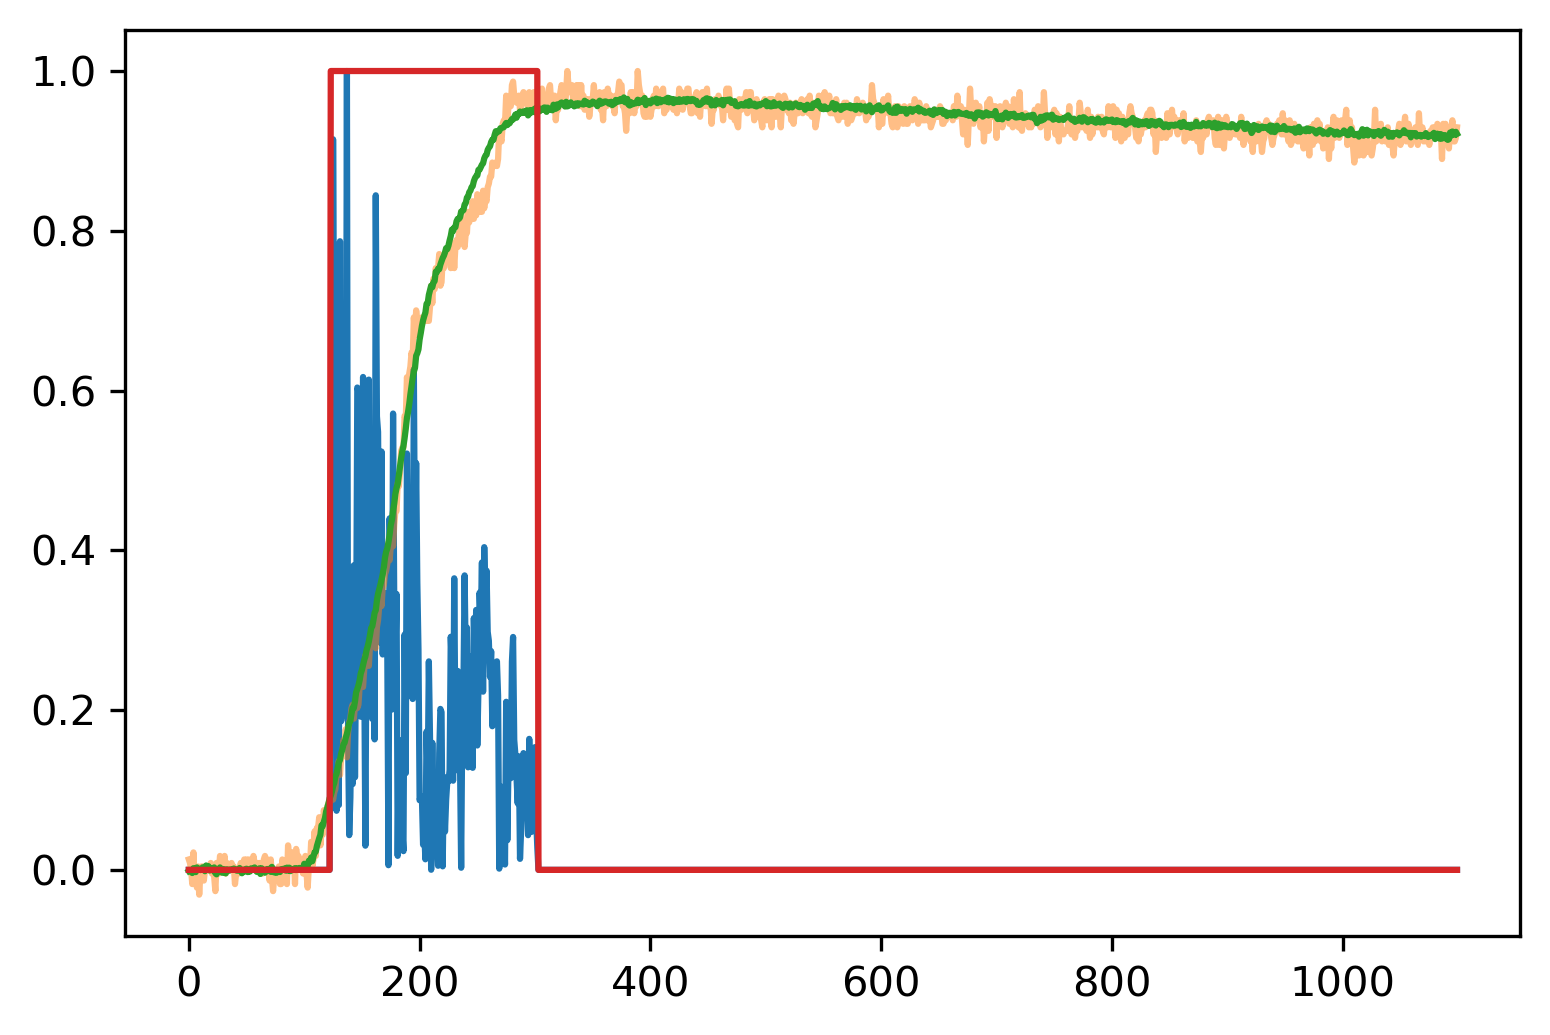

In [350]:


plt.plot(val/max(val))
plt.plot(cs_photopeak_zero[i], alpha=0.5)
plt.plot(kmeans.cluster_centers_[kmeans.labels_[i]])
plt.plot(weight)

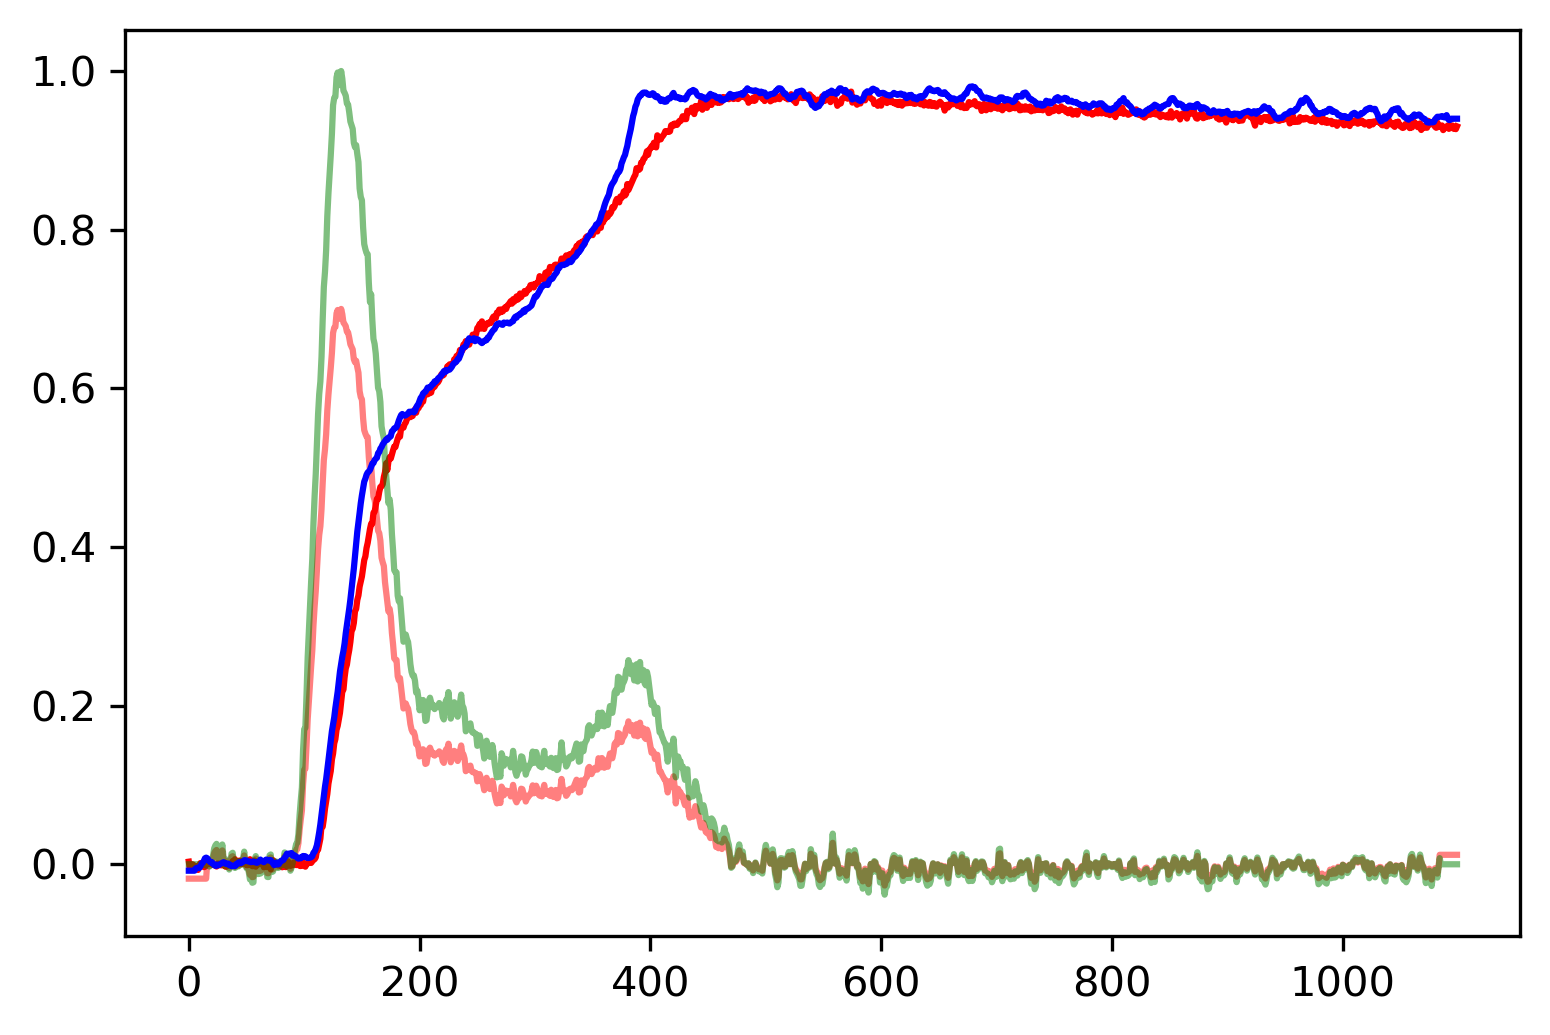

In [370]:
i = 100
plt.plot(kmeans.cluster_centers_[kmeans.labels_[i]], color='r')
plt.plot(savgol_filter(np.gradient(kmeans.cluster_centers_[kmeans.labels_[i]])/max(np.gradient(kmeans.cluster_centers_[kmeans.labels_[i]])), 31, 0), c='r', alpha=0.5)
plt.plot(np.gradient(savgol_filter(kmeans.cluster_centers_[kmeans.labels_[i]], 31, 0))/max(np.gradient(savgol_filter(kmeans.cluster_centers_[kmeans.labels_[i]], 31, 0))), c='g', alpha=0.5)
plt.plot(savgol_filter(cs_photopeak_zero[i], 11, 0), color='b')